# 0. Required Environment

In [4]:
!pip install igdb-api-v4
!pip install roboflow
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 734 kB/s 
     |████████████████████████████████| 145 kB 8.4 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 138 kB 67.8 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
     |████████████████████████████████| 178 kB 74.3 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=9d30e2712b892d176bcc552569d154d3375aa4bef999b87b045689f28cbadeb7
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 536 kB/s 


In [5]:
!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 5.3 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 1.6 MB 70.4 MB/s 


In [6]:
import requests
from igdb.wrapper import IGDBWrapper
import json

from glob import glob

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import urllib.request
import os

from os.path import exists

import pandas as pd
from roboflow import Roboflow

import numpy as np

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
from math import cos, sin, radians, log10
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import PIL
import torchvision.models as models
import cv2

In [ ]:
# # mount drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# main_dir = "/Images/"
main_dir = "./Image_5000/"

In [ ]:
mps_device = torch.device("mps")

# 1. Initialize Dataset

### 1.1. Download Image Dataset

In [ ]:
client_id = "7bfao5qocpm1481cx9o7x0wevid8q4"
client_secret = "wqwk60dbrsikcwzkqs89e958tiso7q"

response = requests.post(f"https://id.twitch.tv/oauth2/token?client_id={client_id}&client_secret={client_secret}&grant_type=client_credentials")
access_token = json.loads(response.text)["access_token"]
wrapper = IGDBWrapper(client_id, access_token)

In [ ]:
# JSON API request
def downloading_img(num_img):
  offset = 0
  output = []

  result = []

  while (offset <= num_img):
    byte_array = wrapper.api_request('games', 
                                    f'fields name, themes.name, total_rating, id, cover.url; offset {offset}; where total_rating_count > 5 & cover != 0 & platforms = \{48,49, 6, 130}; sort first_release_date; limit 500;')
    output.extend(json.loads(byte_array))
    offset += 500

  for i in output:
    if 'name' not in i or 'cover' not in i or 'themes' not in i or 'total_rating' not in i:
      continue
    else:
      i['cover']['url'] = 'https:' + i['cover']['url'].replace('t_thumb', 't_cover_big')

      result.append(i)

  return result

In [ ]:
def show_img(img_url):
  response = requests.get(img_url)
  img = Image.open(BytesIO(response.content))
  imgplot = plt.imshow(img)
  plt.show()

def download_single_img(img_url, file_dir):
  # urllib.request.urlretrieve(img_url, file_dir)
  response = requests.get(img_url)
  # Save the image
  if response.status_code == 200:
    with open(file_dir, "wb") as f:
        f.write(response.content)

In [ ]:
def loading_img_into_dir(images, main_dir=main_dir):
  count = 0
  for i in images:
    name = i['name']
    rating = i['total_rating']
    theme_name = []
    for j in i['themes']: theme_name.append(j['name'])
    img_url = i['cover']['url']
    id = i['id']
    
    file_name = os.path.join(main_dir, f'{id}.jpg')

    if not exists(file_name): download_single_img(img_url, file_name)

    count += 1
    if count % 100 == 0:
      print(f'{count}/{len(images)}')

In [ ]:
def save_csv(output, main_dir = main_dir):
  names = []
  ratings = []
  theme_names = []
  img_url = []
  id = []
  for i in output:
    names.append(i['name'])
    ratings.append(i['total_rating'])
    theme = []
    for j in i['themes']:
      theme.append(j['name'])
    theme_names.append(theme)
    img_url.append(i['cover']['url'])
    id.append(i['id'])

  df = pd.DataFrame([id, names, theme_names, ratings, img_url]).T
  df.rename({0:'id', 1:'name', 2:'theme', 3:'rating', 4:'img url'}, axis=1)
  df.to_csv(os.path.join(main_dir + '.csv'))

In [ ]:
output = downloading_img(5000)
loading_img_into_dir(output)

In [ ]:
# !zip -r '/content/gdrive/MyDrive/DLCV 4995 Final Project/Image_5000.zip' '/content/gdrive/MyDrive/DLCV 4995 Final Project/Image_5000/'

In [ ]:
save_csv(output)

### 1.2. Using Roboflow to bound image text

In [ ]:
def upload_image_into_roboflow(images, main_dir = main_dir):
  rf = Roboflow(api_key="goJwAwFJF3ZclJiMiOUo")
  workspace = rf.workspace()

  project = workspace.project("dlcv")

  count = 0

  for i in images:
    id = i['id']
    project.upload(os.path.join(main_dir, f'{id}.jpg'))

    count += 1
    if count % 100 == 0:
      print(f'{count}/{len(output)}')

In [ ]:
!unzip '/content/gdrive/MyDrive/DLCV 4995 Final Project/labels_5000.zip' -d '/content/gdrive/MyDrive/DLCV 4995 Final Project/Labels/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/MyDrive/DLCV 4995 Final Project/Labels/labels/95005_jpg.rf.475791ff78fdfebc1f0f3825835887b4.txt  
  inflating: /content/gdrive/MyDrive/DLCV 4995 Final Project/Labels/__MACOSX/labels/._95005_jpg.rf.475791ff78fdfebc1f0f3825835887b4.txt  
  inflating: /content/gdrive/MyDrive/DLCV 4995 Final Project/Labels/labels/16611_jpg.rf.ddab9ad3c07d4ee1a9dd4308016ebe7a.txt  
  inflating: /content/gdrive/MyDrive/DLCV 4995 Final Project/Labels/__MACOSX/labels/._16611_jpg.rf.ddab9ad3c07d4ee1a9dd4308016ebe7a.txt  
  inflating: /content/gdrive/MyDrive/DLCV 4995 Final Project/Labels/labels/9879_jpg.rf.cfdd8874c7f1631cfc611ed00ea6e0a4.txt  
  inflating: /content/gdrive/MyDrive/DLCV 4995 Final Project/Labels/__MACOSX/labels/._9879_jpg.rf.cfdd8874c7f1631cfc611ed00ea6e0a4.txt  
  inflating: /content/gdrive/MyDrive/DLCV 4995 Final Project/Labels/labels/36278_jpg.rf.fcc5beedf6c4051f784affcd2469dac0.txt  
  inflating: /content/gdrive/

### 1.3. Data Preprocess


In [ ]:
filenames = [os.path.basename(x) for x in glob('labels/*')]
new_filenames = []
for f in filenames:
    filename = 'labels/' + f
    if (os.stat(filename).st_size != 0):
        new_filenames.append(f)
        
print(len(new_filenames))

4532


In [ ]:
class GameCoverDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, start, end, filenames, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and landmarks.
            start (int): starting index
            end (int): ending index
        """
        self.transform = transform
        self.start = start
        self.end = end

        self.root_dir = main_dir
        self.filenames = filenames[start:end]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        /
        landmark = [] # face bounding box used to crop the image

        filename = self.root_dir + 'labels/' + self.filenames[idx]
        f = open(filename, "r")
        landmark = f.read().split()
        # print(landmark)
        
        img_name = self.root_dir + self.filenames[idx].split('_')[0] + '.jpg'
        # print(img_name)
        img = cv2.imread(img_name)
        
        landmark = np.array(landmark).astype('float32')
        
        if self.transform:
            img, landmark = self.transform(img, landmark)
        
        #if img is None:
        #    return self.__getitem__(idx+1)
        
        return img, landmark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
class GameCoverTransform():
    def __init__(self) -> None:
        pass

    def color_jitter(self, image, landmark):
        res_im = transforms.ColorJitter(contrast=0.5, saturation=0.5, hue=0.5)(image)
        return res_im, landmark

    def translation(self, image, landmark):
        if random.random() > 0.5:
            trans_im = TF.affine(image, 0, [-10, 10], 1, 0, transforms.InterpolationMode.BILINEAR)
            new_landmark = np.flip(landmark, axis=1)
            return trans_im, new_landmark[0]

        return image, landmark

    def rotate(self, image, landmark, angle):
        angle = random.uniform(-angle, +angle)

        # transformation_matrix = torch.tensor([
        #     [+cos(radians(angle)), -sin(radians(angle))], 
        #     [+sin(radians(angle)), +cos(radians(angle))]
        # ])

        rot_image = TF.rotate(image, angle)

        landmarks = landmark - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return rot_image, new_landmarks.float()

    def __call__(self, image, landmark):
        image = transforms.ToPILImage()(image)

        image = image.resize([224, 224], resample=PIL.Image.LANCZOS)

        # image, landmark = self.color_jitter(image, landmark)

        landmark = np.array(landmark)

        # image, landmark = self.rotate(image, landmark, 15)
        
        image_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[1.0]),
        ])

        aug_im = image_transforms(image)

        return aug_im, landmark

In [ ]:
train_dataset = GameCoverDataset(0, 100, new_filenames, GameCoverTransform())
# test_dataset = GameCoverDataset(3000, 4000, filenames, GameCoverTransform)
valid_dataset = GameCoverDataset(100, 150, new_filenames, GameCoverTransform())

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 1)

# 2. Bounding Box Detect [**NOT WORKING, GO TO 7**]

### 2.1. YOLO

In [ ]:
# Model
yolov5 = torch.hub.load('ultralytics/yolov5', 'yolov5n', classes =1)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-6 Python-3.8.15 torch-1.12.1+cu113 CPU

Overriding model.yaml nc=80 with nc=1

                 from  n    params  module                                  arguments                     
  0                -1  1      1760  models.common.Conv                      [3, 16, 6, 2, 2]              
  1                -1  1      4672  models.common.Conv                      [16, 32, 3, 2]                
  2                -1  1      4800  models.common.C3                        [32, 32, 1]                   
  3                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  4                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  5                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  6                -1  3    156928  models.common.C3                        [128, 128

In [ ]:
def train(yolov5, num_epochs, learning_rate):
    # use MSE loss
    criterion = nn.MSELoss()
    # use SGD as optimizer
    optimizer = torch.optim.Adam(yolov5.parameters(), lr=learning_rate)

    train_loss_lst = []
    valid_loss_lst = []
    for epoch in range(num_epochs):  
        running_loss = 0.0
        epoch_acc = 0.0

        cur = 0

        for i, data in enumerate(train_dataloader):

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # inputs, labels = inputs.cuda(), labels.cuda()

            labels = labels.view(labels.size(0),-1)
        
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            outputs = yolov5(inputs)[0]
            outputs = outputs[:,:,:,:,:4]
            outputs = outputs.reshape(outputs.size(0), -1)
            print(outputs.size())
            # outputs.print()
            # print(outputs[0][0][0][0])
            labels = labels[:,1:]
            print(labels.size())

            # compute loss and accuracy
            loss = criterion(outputs, labels)
            acc = calc_acc(outputs, labels)

            # backward pass
            loss.backward()

            # update network parameters
            optimizer.step()

            running_loss += loss.item()
            epoch_acc += acc.item()

            cur += 1
            print(f'batch[{cur}]: loss: {loss.item()}\t|\t acc: {acc.item()}')

        # print statistics
        print('epoch %d, train loss: %.3f, train acc: %.3f' % (epoch + 1, running_loss / len(train_dataloader), epoch_acc / len(train_dataloader)))
        train_loss_lst.append(running_loss/len(train_dataloader))

        # calc validation loss and accuracy
        valid_running_loss = 0.0
        valid_epoch_acc = 0.0
        for i, data in enumerate(valid_dataloader):

            # get the inputs; data is a list of [inputs, labels]
            valid_inputs, valid_labels = data
            # valid_inputs, valid_labels = valid_inputs.cuda(), valid_labels.cuda()

            # forward pass
            valid_outputs = yolov5(valid_inputs)[0]
            valid_outputs = outputs[:,:,:,:,:4]

            # compute loss
            valid_labels = valid_labels.view(valid_labels.size(0),-1)
            valid_loss = criterion(valid_outputs, valid_labels[1:])

            valid_labels = valid_labels[:,1:]

            # calc accuracy
            valid_acc = calc_acc(valid_outputs, valid_labels)
            valid_epoch_acc += valid_acc.item()

        print('epoch %d, valid loss: %.3f, valid acc: %.3f' % (epoch + 1, valid_running_loss / len(valid_dataloader), valid_epoch_acc / len(valid_dataloader)))

            

In [ ]:
def calc_acc(pred, label):
    # round the prediction to 0 or 1 to get predicted tags, compare the predicted tags with the 
    # actual label and count the number of correct predictions
    correct = (torch.round(pred).flatten() == label.flatten()).flatten().sum().float()
    # divide number of correct predictions by total data points
    acc = correct/label.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [ ]:
train(yolov5, 1, 0.0001)

torch.Size([1, 9408])
torch.Size([1, 4])


RuntimeError: ignored

### 2.2. RESNET

In [ ]:
def train(resnet18, num_epochs, learning_rate):
  # use BCE loss
  criterion = nn.MSELoss()
  # use SGD as optimizer
  optimizer = torch.optim.SGD(resnet18.parameters(), lr=learning_rate, momentum=0.9)
  # the sigmoid that is to be applied after output
  # m = nn.Sigmoid()

  train_loss_lst = []
  valid_loss_lst = []
  for epoch in range(num_epochs):  
      running_loss = 0.0
      epoch_acc = 0.0

      cur = 0

      for i, data in enumerate(train_dataloader):

          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          # inputs, labels = inputs.cuda(), labels.cuda()

          labels = labels.view(labels.size(0),-1)
      
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward pass
          outputs = resnet18(inputs)
          # print(inputs.size())
          # print(outputs.size())
          # print(labels.size())


          # compute loss and accuracy
          loss = criterion(outputs, labels)
          acc = calc_acc(outputs, labels)

          # backward pass
          loss.backward()

          # update network parameters
          optimizer.step()

          running_loss += loss.item()
          epoch_acc += acc.item()

          cur += 1
        
          print(f'batch[{cur}]: loss: {loss.item()}\t|\t acc: {acc.item()}')

      # print statistics
      print('epoch %d, train loss: %.3f, train acc: %.3f' % (epoch + 1, running_loss / len(train_dataloader), epoch_acc / len(train_dataloader)))
      train_loss_lst.append(running_loss/len(train_dataloader))

      # calc validation loss and accuracy
      valid_running_loss = 0.0
      valid_epoch_acc = 0.0
      for i, data in enumerate(valid_dataloader):

          # get the inputs; data is a list of [inputs, labels]
          valid_inputs, valid_labels = data
          # valid_inputs, valid_labels = valid_inputs.cuda(), valid_labels.cuda()

          # forward pass
          valid_outputs = resnet18(valid_inputs)

          # compute loss
          valid_labels = valid_labels.view(valid_labels.size(0),-1)
          valid_loss = criterion(valid_outputs, valid_labels)


          valid_running_loss += valid_loss.item()

          # calc accuracy
          valid_acc = calc_acc(valid_outputs, valid_labels)
          valid_epoch_acc += valid_acc.item()

      print('epoch %d, valid loss: %.3f, valid acc: %.3f' % (epoch + 1, valid_running_loss / len(valid_dataloader), valid_epoch_acc / len(valid_dataloader)))


def calc_acc(pred, label):
    # round the prediction to 0 or 1 to get predicted tags, compare the predicted tags with the 
    # actual label and count the number of correct predictions
    correct = (torch.round(pred).flatten() == label.flatten()).flatten().sum().float()
    # divide number of correct predictions by total data points
    acc = correct/label.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [ ]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained = True)

for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = nn.Linear(in_features = 512, out_features = 5, bias = True)

In [ ]:
train(resnet18, 1, 0.001)

batch[1]: loss: 0.8142832517623901	|	 acc: 25.0
batch[2]: loss: 0.590793788433075	|	 acc: 31.0
batch[3]: loss: 0.3320576846599579	|	 acc: 62.0
batch[4]: loss: 0.1767081320285797	|	 acc: 81.0
batch[5]: loss: 0.14754247665405273	|	 acc: 62.0
batch[6]: loss: 0.22383494675159454	|	 acc: 69.0
batch[7]: loss: 0.3172270357608795	|	 acc: 50.0
epoch 1, train loss: 0.372, train acc: 54.286
epoch 1, valid loss: 0.458, valid acc: 34.500


In [ ]:
# import torch

# # Model
# model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# # Image
# im = os.path.join(main_dir + '/test/1.png')

# # Inference
# results = model(im)

# results.pandas().xyxy[0]


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-6 Python-3.8.15 torch-1.12.1+cu113 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, confidence, class, name]
Index: []

### 2.3. RCNN

In [ ]:
def train(model, num_epochs, learning_rate):
  # use BCE loss
  criterion = nn.MSELoss()
  # use SGD as optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
  # the sigmoid that is to be applied after output
  # m = nn.Sigmoid()

  train_loss_lst = []
  valid_loss_lst = []
  for epoch in range(num_epochs):  
      running_loss = 0.0
      epoch_acc = 0.0

      cur = 0

      for i, data in enumerate(train_dataloader):

          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          # inputs, labels = inputs.cuda(), labels.cuda()

          # labels = labels.view(labels.size(0),-1)
          targets = []
          for l in labels:
            d = {}
            d['boxes'] = l[1:]
            x_center = d['boxes'][0]
            y_center = d['boxes'][1]
            width = d['boxes'][2]
            height = d['boxes'][3]
            x_min = x_center - width/2
            y_min = y_center - height/2
            x_max = x_center + width/2
            y_max = y_center + height/2
            d['boxes'] = torch.tensor(np.array([x_min, y_min, x_max, y_max]))

            d['boxes'] = d['boxes'].view(-1, d['boxes'].size(0))

            # l_arr = (l[0].to(torch.int64)).numpy()
            # d['labels'] = torch.tensor(l_arr)#.to(torch.int64)
            d['labels'] = (l[0].to(torch.int64)).view(1, 1)[0]
            # print(d['labels'])
            targets.append(d)

          # targets = np.array(targets).astype('int64'))
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward pass
          outputs = model(inputs, targets)
          # print(inputs.size())
          # print(model(inputs))
          # print(labels)
          
          # print(model.eval())

          # compute loss and accuracy
          # loss = criterion(outputs, labels)
          # acc = calc_acc(outputs, labels)

          # backward pass
          # loss.backward()

          # update network parameters
          # optimizer.step()

          running_loss += outputs['loss_classifier']
          # epoch_acc += model(inputs)

          cur += 1
          model.eval()

          #test = einops.rearrange(inputs[0], "h w c -> c h w").squeeze()

          # print(inputs[0].size())
          test = [inputs[0]]
          print(len(test))
          print(test[0].size())
          print(model(test))
        
          print(f'batch[{cur}]: loss: {loss.item()}\t|\t acc: {acc.item()}')

      # print statistics
      print('epoch %d, train loss: %.3f, train acc: %.3f' % (epoch + 1, running_loss / len(train_dataloader), epoch_acc / len(train_dataloader)))
      train_loss_lst.append(running_loss/len(train_dataloader))

      # calc validation loss and accuracy
      valid_running_loss = 0.0
      valid_epoch_acc = 0.0
      for i, data in enumerate(valid_dataloader):

          # get the inputs; data is a list of [inputs, labels]
          valid_inputs, valid_labels = data
          # valid_inputs, valid_labels = valid_inputs.cuda(), valid_labels.cuda()

          # forward pass
          valid_outputs = model(valid_inputs)

          # compute loss
          valid_labels = valid_labels.view(valid_labels.size(0),-1)
          valid_loss = criterion(valid_outputs, valid_labels)


          valid_running_loss += valid_loss.item()

          # calc accuracy
          valid_acc = calc_acc(valid_outputs, valid_labels)
          valid_epoch_acc += valid_acc.item()

      print('epoch %d, valid loss: %.3f, valid acc: %.3f' % (epoch + 1, valid_running_loss / len(valid_dataloader), valid_epoch_acc / len(valid_dataloader)))


def calc_acc(pred, label, dataloader = None):

    # if dataloader:
    #     correct = 0
    #     for i, data in enumerate(dataloader):

    #       # get the inputs; data is a list of [inputs, labels]
    #       valid_inputs, valid_labels = data
    #       # valid_inputs, valid_labels = valid_inputs.cuda(), valid_labels.cuda()
          
    #       pred = model(valid_inputs)
    #       correct += (torch.round(pred).flatten() == label.flatten()).flatten().sum().float()
    #     return correct / len(dataloader)

    # round the prediction to 0 or 1 to get predicted tags, compare the predicted tags with the 
    # actual label and count the number of correct predictions
    correct = (torch.round(pred).flatten() == label.flatten()).flatten().sum().float()
    # divide number of correct predictions by total data points
    acc = correct/label.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [ ]:
# import FasterRCNN_ResNet50_FPN_Weights from models.detection
rcnn = models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

rcnn.roi_heads.box_predictor.cls_pred = nn.Linear(in_features = 1024, out_features = 1, bias = True)
rcnn.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features = 1024, out_features = 4, bias = True)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
train(rcnn, 1, 0.001)

IndexError: ignored

In [ ]:
x = [torch.rand(3, 224, 224)]


print(len(x))
print(x[0].size())

rcnn.eval()
rcnn(x)

1
torch.Size([3, 224, 224])


[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

# 3. Theme

### 3.1. Pre-process Data

In [ ]:
data = pd.read_csv('Image_5000.csv')
data = data.rename(columns = {'0': 'id', '1': 'Name', '2': 'Theme', '3': 'Rating', '4': 'URL'})
# labels = data['Theme'].str.strip("[]").str.get_dummies(', ').rename(columns=lambda x: x.strip("'")).iloc[:, :22]
labels = data['Theme'].str.strip("[]").str.get_dummies(', ').rename(columns=lambda x: x.strip("'")).iloc[:, :22].join(data['id']).set_index('id')
theme_label_names = labels.columns

In [ ]:
class GameCoverDataset_Theme(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, start, end, filenames, labels, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and landmarks.
            start (int): starting index
            end (int): ending index
        """
        self.transform = transform
        self.start = start
        self.end = end

        self.root_dir = main_dir
        self.filenames = filenames[start:end]
        self.themes = labels

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        landmark = [] # theme label
        landmark = self.themes.loc[int(self.filenames[idx].split('_')[0])].to_numpy()
        # print(landmark)
        landmark = np.array(landmark).astype('float32')
        
        
        img_name = self.root_dir + self.filenames[idx].split('_')[0] + '.jpg'
        # img = Image.open(img_name)
        img = cv2.imread(img_name)
        
        # print(img_name)

        
        if img is None:
           return self.__getitem__(idx+1)


        if self.transform:
            img, landmark = self.transform(img, landmark)
        
        
        
        return img, landmark

In [ ]:
class GameCoverTransform_Theme():
    def __init__(self) -> None:
        pass

    def color_jitter(self, image, landmark):
        res_im = transforms.ColorJitter(contrast=0.5, saturation=0.5, hue=0.5)(image)
        return res_im, landmark

    def translation(self, image, landmark):
        if random.random() > 0.5:
            trans_im = TF.affine(image, 0, [-10, 10], 1, 0, transforms.InterpolationMode.BILINEAR)
            return trans_im, landmark

        return image, landmark

    def rotate(self, image, landmark, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        rot_image = TF.rotate(image, angle)

        return rot_image, landmark

    def __call__(self, image, landmark):
        image = transforms.ToPILImage()(image)

        image = image.resize([224, 224], resample=PIL.Image.LANCZOS)

        image, landmark = self.color_jitter(image, landmark)
        image, landmark = self.rotate(image, landmark, 15)
        
        image_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[1.0]),
        ])

        aug_im = image_transforms(image)

        return aug_im, landmark

In [ ]:
train_dataset = GameCoverDataset_Theme(0, 3500, new_filenames, labels, GameCoverTransform_Theme())
test_dataset = GameCoverDataset_Theme(3500, 4000, new_filenames, labels, GameCoverTransform_Theme())
valid_dataset = GameCoverDataset_Theme(4000, 4500, new_filenames, labels, GameCoverTransform_Theme())

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 64)
valid_dataloader = DataLoader(valid_dataset, batch_size = 64)

### 3.2. Theme Model

In [ ]:
class Theme_Model():
    def __init__(self, model, num_epochs, learning_rate):
        self.model = model
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate

    def train(self):
        num_epochs = self.num_epochs
        learning_rate = self.learning_rate
        
        # use MSE loss
        self.criterion = nn.MSELoss()
        # use Adam as optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

        self.train_loss_lst = []
        self.train_acc_lst = []
        self.valid_loss_lst = []
        self.valid_acc_lst = []

        for epoch in range(num_epochs):  
            running_loss = 0.0
            epoch_acc = 0.0

            for i, data in enumerate(train_dataloader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs, labels = inputs.to(mps_device), labels.to(mps_device)

                labels = labels.view(labels.size(0),-1)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                outputs = self.model(inputs)

                # compute loss and accuracy
                loss = self.criterion(outputs, labels)
                acc = self.calc_acc(outputs, labels)

                # backward pass
                loss.backward()

                # update network parameters
                optimizer.step()

                running_loss += loss.item()
                epoch_acc += acc

            # print statistics
            print('epoch %d, train loss: %.3f, train acc: %.3f' % (epoch + 1, running_loss / len(train_dataloader), epoch_acc / len(train_dataloader)))
            self.train_loss_lst.append(running_loss/len(train_dataloader))
            self.train_acc_lst.append(epoch_acc/len(train_dataloader))

            # calc validation loss and accuracy
            valid_running_loss = 0.0
            valid_epoch_acc = 0.0
            for i, data in enumerate(valid_dataloader):

                # get the inputs; data is a list of [inputs, labels]
                valid_inputs, valid_labels = data
                valid_inputs, valid_labels = valid_inputs.to(mps_device), valid_labels.to(mps_device)

                # forward pass
                valid_outputs = self.model(valid_inputs)

                # compute loss
                valid_loss = self.criterion(valid_outputs, valid_labels)
                valid_running_loss += valid_loss.item()

                # calc accuracy
                valid_acc = self.calc_acc(valid_outputs, valid_labels)
                valid_epoch_acc += valid_acc

            print('epoch %d, valid loss: %.3f, valid acc: %.3f' % (epoch + 1, valid_running_loss / len(valid_dataloader), valid_epoch_acc / len(valid_dataloader)))

            self.valid_loss_lst.append(valid_running_loss/len(valid_dataloader))
            self.valid_acc_lst.append(valid_epoch_acc/len(valid_dataloader))

    def test(self):
        test_loss = 0.0
        test_acc = 0.0
        
        for i, data in enumerate(test_dataloader):
            # get the inputs; data is a list of [inputs, labels]
            test_inputs, test_labels = data
            test_inputs, test_labels = test_inputs.to(mps_device), test_labels.to(mps_device)

            # forward pass
            test_outputs = self.model(test_inputs)

            # calc accuracy
            test_epoch_acc = self.calc_acc(test_outputs, test_labels)
            test_acc += test_epoch_acc

        print('test acc: %.3f' % (test_acc / len(test_dataloader)))

    def calc_acc(self, pred, label, dataloader = None):
        # round the prediction to 0 or 1 to get predicted tags, compare the predicted tags with the 
        # actual label and count the number of correct predictions
        pred = torch.round(pred)
        correct = (torch.round(pred).flatten() == label.flatten()).flatten().sum().float()
        
        # divide number of correct predictions by total data points
        acc = correct/label.numel()
        acc = torch.round(acc * 100)
        return acc

    def save_model(self, filename):
        torch.save(self.model.state_dict(), filename)
    
    def load_model(self, filename):
        self.model.load_state_dict(torch.load(filename))

In [ ]:
def theme_predict(model, img_filename):
    img = cv2.imread(img_filename)
    img = transforms.ToPILImage()(img)
    # convert to tensor
    img = img.resize([224, 224], resample=PIL.Image.LANCZOS)

    image_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[1.0]),
    ])
    img = image_transforms(img)
    img = img.view(1, 3, 224, 224)
    img = img.to(mps_device)
    # forward pass
    output = model(img)
    output = output.cpu()

    output = torch.argsort(output, descending=True).numpy()

    result = []
    result.append(theme_label_names[output[0][0]])
    result.append(theme_label_names[output[0][1]])

    return result

### 3.3. Loading and Training Models

##### 3.3.1. Resnet18

In [ ]:
from torchvision.models.resnet import ResNet18_Weights
theme_resnet18 = models.resnet18(weights = ResNet18_Weights.DEFAULT)

for param in theme_resnet18.parameters():
    param.requires_grad = False
theme_resnet18.fc = nn.Linear(in_features = 512, out_features = 22)

theme_resnet18.to(mps_device)

theme_resnet18_model = Theme_Model(theme_resnet18, 10, 1e-4)

In [ ]:
theme_resnet18_model.train()
theme_resnet18_model.save_model('theme_resnet18_model.pt')

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


epoch 1, train loss: 0.272, train acc: 69.800
epoch 1, valid loss: 0.214, valid acc: 74.875
epoch 2, train loss: 0.198, train acc: 76.582
epoch 2, valid loss: 0.184, valid acc: 78.250
epoch 3, train loss: 0.180, train acc: 78.964
epoch 3, valid loss: 0.170, valid acc: 80.375
epoch 4, train loss: 0.164, train acc: 81.164
epoch 4, valid loss: 0.158, valid acc: 82.250
epoch 5, train loss: 0.152, train acc: 82.964
epoch 5, valid loss: 0.147, valid acc: 83.375
epoch 6, train loss: 0.141, train acc: 84.436
epoch 6, valid loss: 0.137, valid acc: 85.125
epoch 7, train loss: 0.132, train acc: 85.545
epoch 7, valid loss: 0.130, valid acc: 85.875
epoch 8, train loss: 0.125, train acc: 86.582
epoch 8, valid loss: 0.123, valid acc: 87.375
epoch 9, train loss: 0.119, train acc: 87.309
epoch 9, valid loss: 0.116, valid acc: 87.875
epoch 10, train loss: 0.114, train acc: 88.000
epoch 10, valid loss: 0.111, valid acc: 88.500


In [ ]:
# temp_resnet18_model = Theme_Model(theme_resnet18, 1, 1e-4)
# temp_resnet18_model.load_model('theme_resnet18_model.pt')
theme_resnet18_model.test()

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


test acc: 88.375


LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


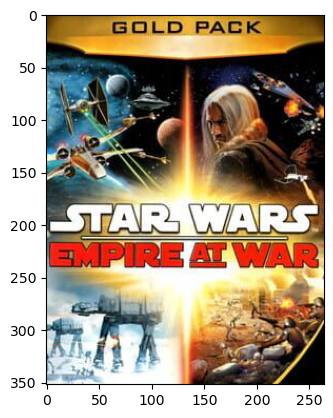

Actual Theme:  ['Science fiction']
Predict:  ['Action', 'Fantasy']


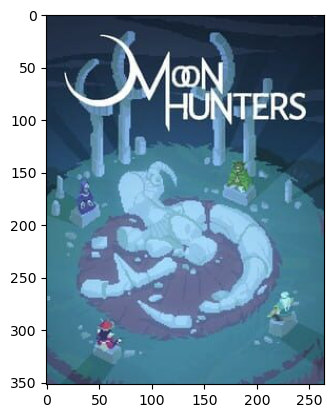

Actual Theme:  ['Action' 'Fantasy' 'Party']
Predict:  ['Action', 'Science fiction']


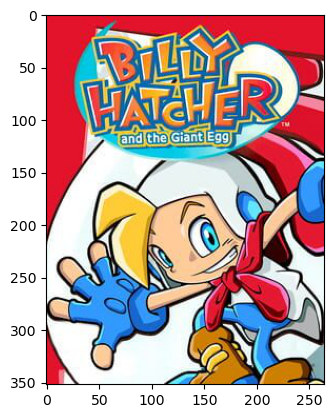

Actual Theme:  ['Action']
Predict:  ['Action', 'Science fiction']


In [ ]:
pred_them_model_resnet18 = Theme_Model(theme_resnet18, 1, 1e-4)
pred_them_model_resnet18.load_model('theme_resnet18_model.pt')
pred_them_model_resnet18.model.to(mps_device)

for i in range(3):
    idx = random.randint(0, len(new_filenames))
    label_id = int(new_filenames[idx].split('_')[0])

    file_name = main_dir + new_filenames[idx].split('_')[0] + '.jpg'
    result = theme_predict(pred_them_model_resnet18.model, file_name)
    ans = (labels.loc[label_id] == 1)
    img = mpimg.imread(file_name)
    imgplot = plt.imshow(img)
    plt.show()
    print('Actual Theme: ', ans[ans == True].index.values)
    print('Predict: ', result)

##### 3.3.2. Resnet50

In [ ]:
from torchvision.models.resnet import ResNet50_Weights
theme_resnet50 = models.resnet50(weights = ResNet50_Weights.DEFAULT)

for param in theme_resnet50.parameters():
    param.requires_grad = False
theme_resnet50.fc = nn.Linear(in_features = 2048, out_features = 22)

theme_resnet50.to(mps_device)

theme_resnet50_model = Theme_Model(theme_resnet50, 10, 1e-4)

In [ ]:
theme_resnet50_model.train()
theme_resnet50_model.save_model('theme_resnet50_model.pt')

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


epoch 1, train loss: 0.087, train acc: 90.345
epoch 1, valid loss: 0.082, valid acc: 91.000
epoch 2, train loss: 0.079, train acc: 91.200
epoch 2, valid loss: 0.081, valid acc: 91.250
epoch 3, train loss: 0.077, train acc: 91.164
epoch 3, valid loss: 0.080, valid acc: 91.125
epoch 4, train loss: 0.076, train acc: 91.145
epoch 4, valid loss: 0.080, valid acc: 91.000
epoch 5, train loss: 0.075, train acc: 91.218
epoch 5, valid loss: 0.079, valid acc: 91.250
epoch 6, train loss: 0.074, train acc: 91.182
epoch 6, valid loss: 0.078, valid acc: 91.125
epoch 7, train loss: 0.073, train acc: 91.291
epoch 7, valid loss: 0.079, valid acc: 91.125
epoch 8, train loss: 0.073, train acc: 91.200
epoch 8, valid loss: 0.078, valid acc: 91.250
epoch 9, train loss: 0.072, train acc: 91.364
epoch 9, valid loss: 0.078, valid acc: 91.250
epoch 10, train loss: 0.071, train acc: 91.345
epoch 10, valid loss: 0.077, valid acc: 91.125


In [ ]:
theme_resnet50_model.test()

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


test acc: 90.875


LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


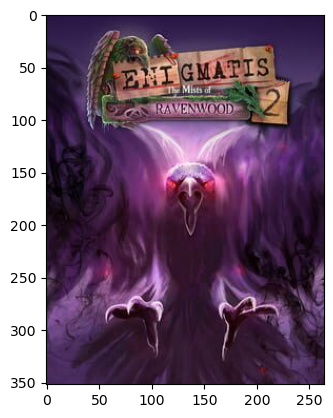

Actual Theme:  ['Mystery']
Predict:  ['Action', 'Fantasy']


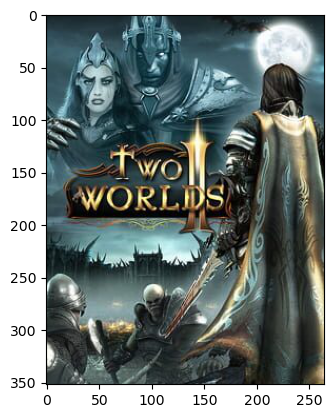

Actual Theme:  ['Action' 'Fantasy' 'Open world']
Predict:  ['Action', 'Fantasy']


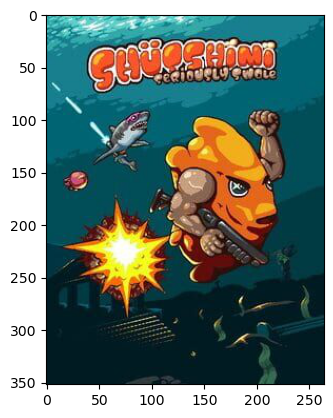

Actual Theme:  ['Action' 'Comedy']
Predict:  ['Action', 'Fantasy']


In [ ]:
pred_them_model_resnet50 = Theme_Model(theme_resnet50, 1, 1e-4)
pred_them_model_resnet50.load_model('theme_resnet50_model.pt')
pred_them_model_resnet50.model.to(mps_device)

for i in range(3):
    idx = random.randint(0, len(new_filenames))
    label_id = int(new_filenames[idx].split('_')[0])

    file_name = main_dir + new_filenames[idx].split('_')[0] + '.jpg'
    result = theme_predict(pred_them_model_resnet50.model, file_name)
    ans = (labels.loc[label_id] == 1)
    img = mpimg.imread(file_name)
    imgplot = plt.imshow(img)
    plt.show()
    print('Actual Theme: ', ans[ans == True].index.values)
    print('Predict: ', result)

##### 3.3.3. VGG16

In [ ]:
from torchvision.models.vgg import VGG16_Weights
theme_vgg16 = models.vgg16(weights = VGG16_Weights.DEFAULT)

for param in theme_vgg16.parameters():
    param.requires_grad = False
theme_vgg16.classifier[6] = nn.Linear(in_features = 4096, out_features = 22)

theme_vgg16.to(mps_device)

theme_vgg16_model = Theme_Model(theme_vgg16, 10, 1e-4)

In [ ]:
theme_vgg16_model.train()
theme_vgg16_model.save_model('theme_vgg16_model.pt')

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


epoch 1, train loss: 0.225, train acc: 73.691
epoch 1, valid loss: 0.203, valid acc: 75.875
epoch 2, train loss: 0.190, train acc: 77.764
epoch 2, valid loss: 0.174, valid acc: 79.750
epoch 3, train loss: 0.172, train acc: 80.145
epoch 3, valid loss: 0.167, valid acc: 81.500
epoch 4, train loss: 0.158, train acc: 82.455
epoch 4, valid loss: 0.153, valid acc: 82.875
epoch 5, train loss: 0.146, train acc: 84.073
epoch 5, valid loss: 0.143, valid acc: 85.625
epoch 6, train loss: 0.135, train acc: 85.818
epoch 6, valid loss: 0.134, valid acc: 86.250
epoch 7, train loss: 0.125, train acc: 87.073
epoch 7, valid loss: 0.125, valid acc: 87.250
epoch 8, train loss: 0.119, train acc: 87.818
epoch 8, valid loss: 0.121, valid acc: 87.750
epoch 9, train loss: 0.112, train acc: 88.691
epoch 9, valid loss: 0.115, valid acc: 88.750
epoch 10, train loss: 0.108, train acc: 89.018
epoch 10, valid loss: 0.108, valid acc: 89.625


In [ ]:
theme_vgg16_model = Theme_Model(theme_vgg16, 1, 1e-4)
theme_vgg16_model.load_model('theme_vgg16_model.pt')
theme_vgg16_model.test()

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


test acc: 89.500


LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


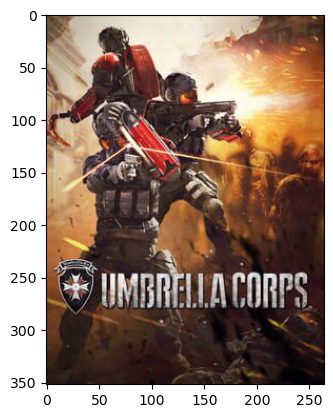

Actual Theme:  ['Action' 'Horror' 'Science fiction']
Predict:  ['Action', 'Science fiction']


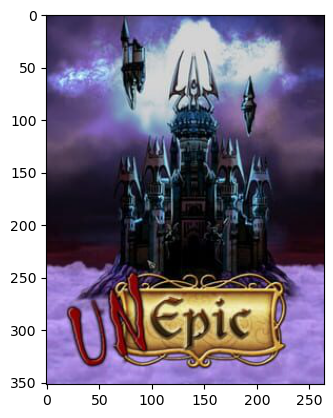

Actual Theme:  ['Action' 'Comedy' 'Fantasy']
Predict:  ['Action', 'Horror']


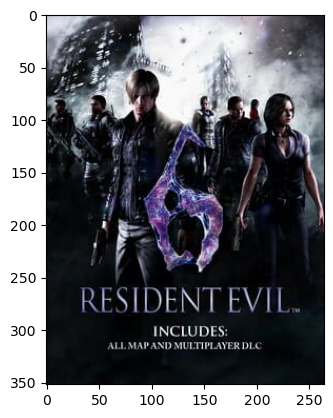

Actual Theme:  ['Action' 'Horror' 'Survival']
Predict:  ['Action', 'Horror']


In [ ]:
pred_them_model_vgg16 = Theme_Model(theme_vgg16, 1, 1e-4)
pred_them_model_vgg16.load_model('theme_vgg16_model.pt')
pred_them_model_vgg16.model.to(mps_device)

for i in range(3):
    idx = random.randint(0, len(new_filenames))
    label_id = int(new_filenames[idx].split('_')[0])

    file_name = main_dir + new_filenames[idx].split('_')[0] + '.jpg'
    result = theme_predict(pred_them_model_vgg16.model, file_name)
    ans = (labels.loc[label_id] == 1)
    img = mpimg.imread(file_name)
    imgplot = plt.imshow(img)
    plt.show()
    print('Actual Theme: ', ans[ans == True].index.values)
    print('Predict: ', result)

# 4. Rating

### 4.1. Pre-Process Data

In [ ]:
# from ast import literal_eval
data = pd.read_csv('Image_5000.csv')
data = data.rename(columns = {'0': 'id', '1': 'Name', '2': 'Theme', '3': 'Rating', '4': 'URL'})
# data = data.explode('Rating')

data_rating = (round(data.Rating / 10) - 1).astype(int).astype(str)
data_rating = data_rating.str.get_dummies().join(data['id']).set_index('id')

data_rating.head()
# print(int(new_filenames[0].split('_')[0]))
# data_rating.loc[41858]

0  1  2  3  4  5  6  7  8  9
id                                 
11859  0  0  0  0  0  1  0  0  0  0
2750   0  0  0  0  0  0  0  1  0  0
2417   0  0  0  0  1  0  0  0  0  0
2872   0  0  0  0  0  0  1  0  0  0
5411   0  0  0  0  0  0  1  0  0  0

In [ ]:
class GameCoverDataset_Rating(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, start, end, filenames, labels, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and landmarks.
            start (int): starting index
            end (int): ending index
        """
        self.transform = transform
        self.start = start
        self.end = end

        self.root_dir = main_dir
        self.filenames = filenames[start:end]
        self.ratings = labels

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        
        # landmark = self.ratings[idx].astype('float32')
        # landmark = np.zeros(10)
        # landmark[int(self.ratings[idx])] = 1
        landmark = self.ratings.loc[int(self.filenames[idx].split('_')[0])].astype('float32').to_numpy()
        # print(landmark)
        
        img_name = self.root_dir + self.filenames[idx].split('_')[0] + '.jpg'
        img = cv2.imread(img_name)
        # cv2_imshow(img)
        
        if img is None:
           return self.__getitem__(idx+1)
                
        if self.transform:
            img, landmark = self.transform(img, landmark)
        
        return img, landmark

In [ ]:
class GameCoverTransform_Rating():
    def __init__(self) -> None:
        pass

    def color_jitter(self, image, landmark):
        res_im = transforms.ColorJitter(contrast=0.5, saturation=0.5, hue=0.5)(image)
        return res_im, landmark

    def translation(self, image, landmark):
        if random.random() > 0.5:
            trans_im = TF.affine(image, 0, [-10, 10], 1, 0, transforms.InterpolationMode.BILINEAR)
            return trans_im, landmark

        return image, landmark

    def rotate(self, image, landmark, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        rot_image = TF.rotate(image, angle)

        return rot_image, landmark

    def __call__(self, image, landmark):
        image = transforms.ToPILImage()(image)

        image = image.resize([224, 224], resample=PIL.Image.LANCZOS)

        image, landmark = self.color_jitter(image, landmark)
        image, landmark = self.rotate(image, landmark, 15)
        
        image_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[1.0]),
        ])

        aug_im = image_transforms(image)

        return aug_im, landmark

In [ ]:
train_dataset = GameCoverDataset_Rating(0, 3500, new_filenames, data_rating, GameCoverTransform_Rating())
test_dataset = GameCoverDataset_Rating(3500,4000, new_filenames, data_rating, GameCoverTransform_Rating())
valid_dataset = GameCoverDataset_Rating(4000,4500, new_filenames, data_rating, GameCoverTransform_Rating())

# train_dataset = GameCoverDataset_Rating(0, 32, new_filenames, data_rating, GameCoverTransform_Rating())
# test_dataset = GameCoverDataset_Rating(32,64, new_filenames, data_rating, GameCoverTransform_Rating())
# valid_dataset = GameCoverDataset_Rating(64,96, new_filenames, data_rating, GameCoverTransform_Rating())

# for i, j in train_dataset:
#   print(j)
#   break

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 64)
valid_dataloader = DataLoader(valid_dataset, batch_size = 64)

### 4.2. Rating Model

In [ ]:
class Rating_Model:
    def __init__(self, model, num_epochs, learning_rate):
        self.model = model
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
    
    def train(self):
        # use MSE loss
        self.criterion = nn.MSELoss()
        # use SGD as optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        self.train_loss_lst = []
        self.train_acc_lst = []

        self.valid_loss_lst = []
        self.valid_acc_lst = []

        for epoch in range(self.num_epochs):  
            running_loss = 0.0
            epoch_acc = 0.0

            for i, data in enumerate(train_dataloader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs, labels = inputs.to(mps_device), labels.to(mps_device)

                labels = labels.view(labels.size(0),-1)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                outputs = self.model(inputs)
              
                # compute loss and accuracy
                loss = self.criterion(outputs, labels)
                acc = self.calc_acc(outputs, labels)

                # backward pass
                loss.backward()

                # update network parameters
                optimizer.step()

                running_loss += loss.item()
                epoch_acc += acc

            # print statistics
            print('epoch %d, train loss: %.3f, train acc: %.3f' % (epoch + 1, running_loss / len(train_dataloader), epoch_acc / len(train_dataloader)))
            self.train_loss_lst.append(running_loss/len(train_dataloader))
            self.train_acc_lst.append(epoch_acc.cpu().data/len(train_dataloader))

            # calc validation loss and accuracy
            valid_running_loss = 0.0
            valid_epoch_acc = 0.0
            for i, data in enumerate(valid_dataloader):
                # get the inputs; data is a list of [inputs, labels]
                valid_inputs, valid_labels = data
                valid_inputs, valid_labels = valid_inputs.to(mps_device), valid_labels.to(mps_device)

                # forward pass
                valid_outputs = self.model(valid_inputs)

                # compute loss
                valid_loss = self.criterion(valid_outputs, valid_labels)
                valid_running_loss += valid_loss.item()

                # calc accuracy
                valid_acc = self.calc_acc(valid_outputs, valid_labels)
                valid_epoch_acc += valid_acc

            print('epoch %d, valid loss: %.3f, valid acc: %.3f' % (epoch + 1, valid_running_loss / len(valid_dataloader), valid_epoch_acc / len(valid_dataloader)))
            self.valid_loss_lst.append(valid_running_loss/len(valid_dataloader))
            self.valid_acc_lst.append(valid_epoch_acc.cpu().data/len(valid_dataloader))

    def test(self):
        # calc test loss and accuracy
        test_running_loss = 0.0
        test_epoch_acc = 0.0
        for i, data in enumerate(test_dataloader):
            # get the inputs; data is a list of [inputs, labels]
            test_inputs, test_labels = data
            test_inputs, test_labels = test_inputs.to(mps_device), test_labels.to(mps_device)

            # forward pass
            test_outputs = self.model(test_inputs)

            # calc accuracy
            test_acc = self.calc_acc(test_outputs, test_labels)
            test_epoch_acc += test_acc
        
        print('test acc: %.3f' % (test_epoch_acc / len(test_dataloader)))
        self.test_loss = test_running_loss/len(test_dataloader)
        self.test_acc = test_epoch_acc.cpu().data/len(test_dataloader)

    def plot_loss(self):
        # plt.subplot(1,1,1)
        plt.plot(self.train_loss_lst, label = 'train loss')
        plt.plot(self.valid_loss_lst, label = 'valid loss')
        plt.xlabel = 'epoch'
        plt.ylabel = 'loss'
        plt.legend()
        
        plt.show()

        # plt.subplot(1,1,1)
        plt.plot(self.train_acc_lst, label = 'train acc')
        plt.plot(self.valid_acc_lst, label = 'valid acc')
        plt.xlabel = 'epoch'
        plt.ylabel = 'acc'
        plt.legend()
        
        plt.show()

    def predict(self, img_filename):
        img = cv2.imread(img_filename)
        img = transforms.ToPILImage()(img)
        # convert to tensor
        img = img.resize([224, 224], resample=PIL.Image.LANCZOS)

        image_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[1.0]),
        ])
        img = image_transforms(img)
        img = img.view(1, 3, 224, 224)
        img = img.to(mps_device)
        # forward pass
        output = self.model(img)
        # convert to numpy
        output = torch.argmax(output.cpu())
        # print(output)

        output = output.numpy() * 10 + 10
        
        return output

    def calc_acc(self, pred, label, dataloader = None):
        # round the prediction to 0 or 1 to get predicted tags, compare the predicted tags with the 
        # actual label and count the number of correct predictions
        correct = (torch.argmax(pred, dim =1) == torch.argmax(label, dim =1)).flatten().sum().float()

        # divide number of correct predictions by total data points
        acc = correct/label.size()[0]
        acc = torch.round(acc * 100)
        return acc

    def save_model(self, filename):
        torch.save(self.model.state_dict(), filename)
    
    def load_model(self, filename):
        self.model.load_state_dict(torch.load(filename))

In [ ]:
def rating_predict(model, img_filename):
    img = cv2.imread(img_filename)
    img = transforms.ToPILImage()(img)
    # convert to tensor
    img = img.resize([224, 224], resample=PIL.Image.LANCZOS)

    image_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[1.0]),
    ])
    img = image_transforms(img)
    img = img.view(1, 3, 224, 224)
    img = img.to(mps_device)
    # forward pass
    output = model(img)
    output = output.cpu()

    output = torch.argmax(output).numpy()

    result = output * 10

    return result

### 4.3. Loading and Training Models

##### 4.3.1. Resnet18

In [ ]:
from torchvision.models.resnet import ResNet18_Weights
rating_resnet18 = models.resnet18(weights = ResNet18_Weights.DEFAULT)

for param in rating_resnet18.parameters():
    param.requires_grad = False
rating_resnet18.fc = nn.Linear(in_features = 512, out_features = 10)

rating_resnet18.to(mps_device)

rating_resnet18_model = Rating_Model(rating_resnet18, 10, 1e-4)

In [ ]:
rating_resnet18_model.train()
rating_resnet18_model.save_model('rating_resnet18_model.pt')

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


epoch 1, train loss: 0.297, train acc: 19.127
epoch 1, valid loss: 0.223, valid acc: 18.125
epoch 2, train loss: 0.206, train acc: 21.600
epoch 2, valid loss: 0.201, valid acc: 19.500
epoch 3, train loss: 0.187, train acc: 21.873
epoch 3, valid loss: 0.182, valid acc: 19.125
epoch 4, train loss: 0.173, train acc: 22.364
epoch 4, valid loss: 0.166, valid acc: 20.250
epoch 5, train loss: 0.159, train acc: 22.255
epoch 5, valid loss: 0.158, valid acc: 21.375
epoch 6, train loss: 0.150, train acc: 23.818
epoch 6, valid loss: 0.147, valid acc: 22.625
epoch 7, train loss: 0.140, train acc: 24.564
epoch 7, valid loss: 0.139, valid acc: 23.250
epoch 8, train loss: 0.135, train acc: 25.073
epoch 8, valid loss: 0.134, valid acc: 26.250
epoch 9, train loss: 0.128, train acc: 26.364
epoch 9, valid loss: 0.129, valid acc: 22.875
epoch 10, train loss: 0.122, train acc: 26.873
epoch 10, valid loss: 0.124, valid acc: 26.750


In [ ]:
rating_resnet18_model.test()

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


test acc: 27.000


LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


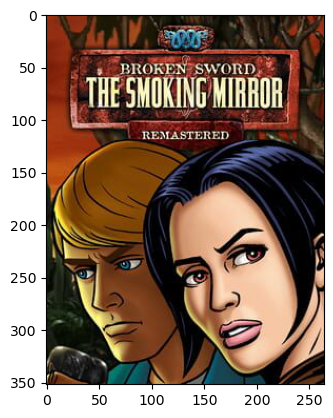

Actual Rating:  80
Predict:  80


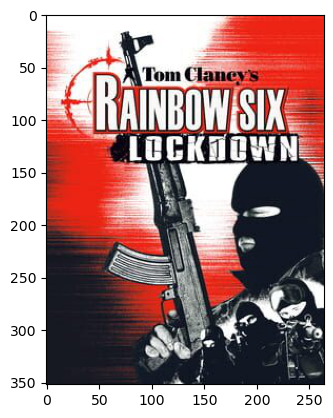

Actual Rating:  70
Predict:  70


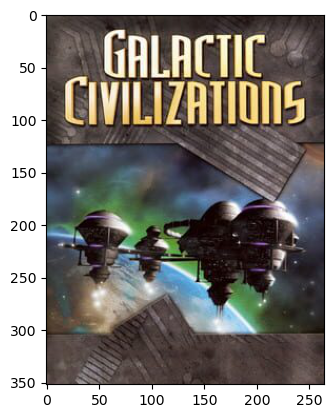

Actual Rating:  80
Predict:  70


In [ ]:
pred_rating_model_resnet18 = Rating_Model(rating_resnet18, 1, 1e-4)
pred_rating_model_resnet18.load_model('rating_resnet18_model.pt')
pred_rating_model_resnet18.model.to(mps_device)

for i in range(3):
    idx = random.randint(0, len(new_filenames))
    label_id = int(new_filenames[idx].split('_')[0])

    file_name = main_dir + new_filenames[idx].split('_')[0] + '.jpg'
    result = rating_predict(pred_rating_model_resnet18.model, file_name)
    ans = (data_rating.loc[label_id] == 1)
    img = mpimg.imread(file_name)
    imgplot = plt.imshow(img)
    act_rating = np.argmax(data_rating.loc[label_id].to_numpy())
    plt.show()
    print('Actual Rating: ', act_rating * 10 + 10)
    print('Predict: ', result + 10)

##### 4.3.2. Resnet50

In [ ]:
from torchvision.models.resnet import ResNet50_Weights
rating_resnet50 = models.resnet50(weights = ResNet50_Weights.DEFAULT)

for param in rating_resnet50.parameters():
    param.requires_grad = False
rating_resnet50.fc = nn.Linear(in_features = 2048, out_features = 10)

rating_resnet50.to(mps_device)

rating_resnet50_model = Rating_Model(rating_resnet50, 10, 1e-4)

In [ ]:
rating_resnet50_model.train()
rating_resnet50_model.save_model('rating_resnet50_model.pt')

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


epoch 1, train loss: 0.089, train acc: 29.600
epoch 1, valid loss: 0.087, valid acc: 31.750
epoch 2, train loss: 0.082, train acc: 35.764
epoch 2, valid loss: 0.084, valid acc: 32.500
epoch 3, train loss: 0.081, train acc: 35.636
epoch 3, valid loss: 0.082, valid acc: 33.750
epoch 4, train loss: 0.079, train acc: 37.145
epoch 4, valid loss: 0.083, valid acc: 31.750
epoch 5, train loss: 0.078, train acc: 37.127
epoch 5, valid loss: 0.081, valid acc: 33.750
epoch 6, train loss: 0.077, train acc: 36.982
epoch 6, valid loss: 0.081, valid acc: 33.125
epoch 7, train loss: 0.076, train acc: 37.836
epoch 7, valid loss: 0.080, valid acc: 33.000
epoch 8, train loss: 0.075, train acc: 40.509
epoch 8, valid loss: 0.081, valid acc: 31.750
epoch 9, train loss: 0.075, train acc: 39.527
epoch 9, valid loss: 0.080, valid acc: 32.250
epoch 10, train loss: 0.075, train acc: 39.636
epoch 10, valid loss: 0.080, valid acc: 35.375


In [ ]:
rating_resnet50_model.test()

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


test acc: 33.875


LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


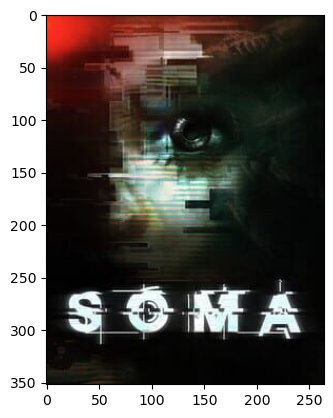

Actual Rating:  80
Predict:  80


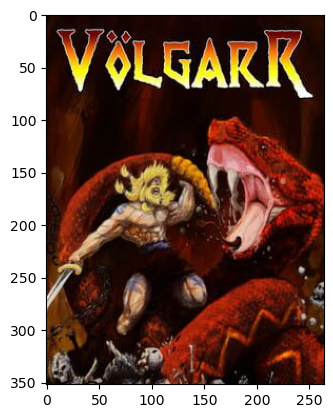

Actual Rating:  80
Predict:  80


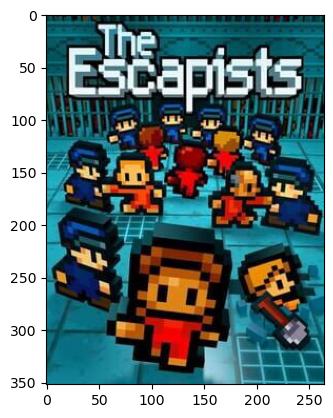

Actual Rating:  60
Predict:  80


In [ ]:
pred_rating_model_resnet50 = Rating_Model(rating_resnet50, 1, 1e-4)
pred_rating_model_resnet50.load_model('rating_resnet50_model.pt')
pred_rating_model_resnet50.model.to(mps_device)

for i in range(3):
    idx = random.randint(0, len(new_filenames))
    label_id = int(new_filenames[idx].split('_')[0])

    file_name = main_dir + new_filenames[idx].split('_')[0] + '.jpg'
    result = rating_predict(pred_rating_model_resnet50.model, file_name)
    ans = (data_rating.loc[label_id] == 1)
    img = mpimg.imread(file_name)
    imgplot = plt.imshow(img)
    act_rating = np.argmax(data_rating.loc[label_id].to_numpy())
    plt.show()
    print('Actual Rating: ', act_rating * 10 + 10)
    print('Predict: ', result + 10)

##### 4.3.3. VGG16

In [ ]:
from torchvision.models.vgg import VGG16_Weights
rating_vgg16 = models.vgg16(weights = VGG16_Weights.DEFAULT)

for param in rating_vgg16.parameters():
    param.requires_grad = False
rating_vgg16.classifier[6] = nn.Linear(in_features = 4096, out_features = 10)

rating_vgg16.to(mps_device)

rating_vgg16_model = Rating_Model(rating_vgg16, 30, 5e-5)

In [ ]:
rating_vgg16_model.train()
rating_vgg16_model.save_model('rating_vgg16_model.pt')

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


epoch 1, train loss: 0.224, train acc: 19.218
epoch 1, valid loss: 0.204, valid acc: 22.500
epoch 2, train loss: 0.194, train acc: 21.218
epoch 2, valid loss: 0.184, valid acc: 20.500
epoch 3, train loss: 0.173, train acc: 22.618
epoch 3, valid loss: 0.170, valid acc: 20.875
epoch 4, train loss: 0.157, train acc: 23.855
epoch 4, valid loss: 0.157, valid acc: 20.875
epoch 5, train loss: 0.146, train acc: 24.564
epoch 5, valid loss: 0.146, valid acc: 25.625
epoch 6, train loss: 0.137, train acc: 25.745
epoch 6, valid loss: 0.138, valid acc: 25.500
epoch 7, train loss: 0.129, train acc: 28.036
epoch 7, valid loss: 0.128, valid acc: 28.500
epoch 8, train loss: 0.122, train acc: 28.582
epoch 8, valid loss: 0.121, valid acc: 27.375
epoch 9, train loss: 0.115, train acc: 30.327
epoch 9, valid loss: 0.121, valid acc: 25.000
epoch 10, train loss: 0.109, train acc: 30.145
epoch 10, valid loss: 0.109, valid acc: 24.750


In [ ]:
rating_vgg16_model.test()

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


test acc: 28.625


LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


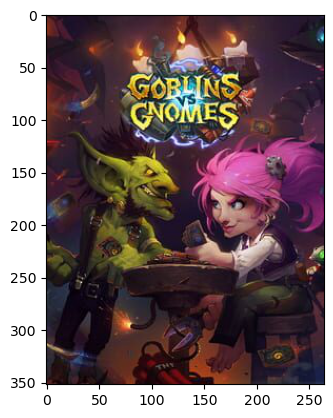

Actual Rating:  80
Predict:  80


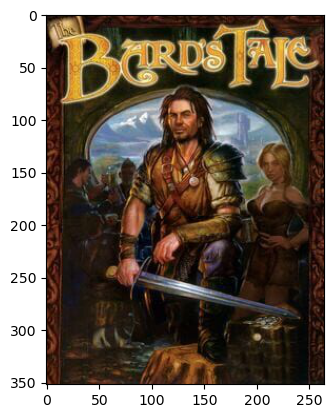

Actual Rating:  70
Predict:  80


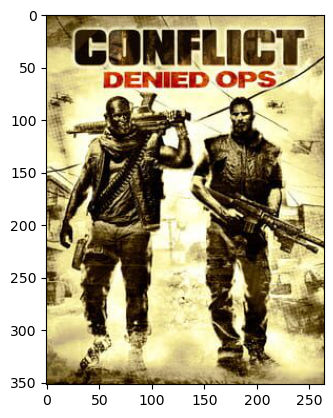

Actual Rating:  50
Predict:  80


In [ ]:
pred_rating_model_vgg16 = Rating_Model(rating_vgg16, 1, 1e-4)
pred_rating_model_vgg16.load_model('rating_vgg16_model.pt')
pred_rating_model_vgg16.model.to(mps_device)

for i in range(3):
    idx = random.randint(0, len(new_filenames))
    label_id = int(new_filenames[idx].split('_')[0])

    file_name = main_dir + new_filenames[idx].split('_')[0] + '.jpg'
    result = rating_predict(pred_rating_model_vgg16.model, file_name)
    ans = (data_rating.loc[label_id] == 1)
    img = mpimg.imread(file_name)
    imgplot = plt.imshow(img)
    act_rating = np.argmax(data_rating.loc[label_id].to_numpy())
    plt.show()
    print('Actual Rating: ', act_rating * 10 + 10)
    print('Predict: ', result + 10)

##### 4.3.4. Modified_Resnet18(30 epoches, 5e-5)

In [ ]:
rating_resnet18_model_modified = Rating_Model(rating_resnet18, 30, 5e-5)
rating_resnet50_model_modified = Rating_Model(rating_resnet50, 30, 5e-5)
rating_vgg16_model_modified = Rating_Model(rating_vgg16, 30, 5e-5)

In [ ]:
rating_resnet18_model_modified.train()

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


epoch 1, train loss: 0.116, train acc: 29.727
epoch 1, valid loss: 0.122, valid acc: 25.375
epoch 2, train loss: 0.112, train acc: 30.073
epoch 2, valid loss: 0.120, valid acc: 24.875
epoch 3, train loss: 0.109, train acc: 30.255
epoch 3, valid loss: 0.115, valid acc: 24.875
epoch 4, train loss: 0.107, train acc: 29.527
epoch 4, valid loss: 0.111, valid acc: 24.500
epoch 5, train loss: 0.104, train acc: 31.909
epoch 5, valid loss: 0.109, valid acc: 24.500
epoch 6, train loss: 0.103, train acc: 30.636
epoch 6, valid loss: 0.108, valid acc: 28.375
epoch 7, train loss: 0.101, train acc: 32.436
epoch 7, valid loss: 0.106, valid acc: 27.000
epoch 8, train loss: 0.098, train acc: 33.636
epoch 8, valid loss: 0.102, valid acc: 28.250
epoch 9, train loss: 0.098, train acc: 32.491
epoch 9, valid loss: 0.103, valid acc: 28.500
epoch 10, train loss: 0.096, train acc: 33.164
epoch 10, valid loss: 0.102, valid acc: 27.375
epoch 11, train loss: 0.094, train acc: 33.364
epoch 11, valid loss: 0.100, va

In [ ]:
rating_resnet18_model_modified.test()

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


test acc: 26.750


In [ ]:
rating_resnet18_model_modified.save_model('rating_resnet18_model_modified.pt')

In [ ]:
rating_resnet50_model_modified.train()

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


epoch 1, train loss: 0.074, train acc: 39.964
epoch 1, valid loss: 0.081, valid acc: 32.000
epoch 2, train loss: 0.074, train acc: 39.964
epoch 2, valid loss: 0.080, valid acc: 34.250
epoch 3, train loss: 0.073, train acc: 40.091
epoch 3, valid loss: 0.081, valid acc: 30.750
epoch 4, train loss: 0.073, train acc: 41.273
epoch 4, valid loss: 0.080, valid acc: 32.875
epoch 5, train loss: 0.073, train acc: 40.909
epoch 5, valid loss: 0.079, valid acc: 33.375
epoch 6, train loss: 0.072, train acc: 41.582
epoch 6, valid loss: 0.079, valid acc: 33.750
epoch 7, train loss: 0.072, train acc: 42.200
epoch 7, valid loss: 0.080, valid acc: 31.625
epoch 8, train loss: 0.072, train acc: 41.873
epoch 8, valid loss: 0.079, valid acc: 33.250
epoch 9, train loss: 0.072, train acc: 41.273
epoch 9, valid loss: 0.079, valid acc: 35.375
epoch 10, train loss: 0.072, train acc: 41.618
epoch 10, valid loss: 0.080, valid acc: 33.125
epoch 11, train loss: 0.072, train acc: 41.945
epoch 11, valid loss: 0.079, va

In [ ]:
rating_resnet50_model_modified.test()

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


test acc: 29.875


In [ ]:
rating_vgg16_model_modified.train()

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


epoch 1, train loss: 0.105, train acc: 31.964
epoch 1, valid loss: 0.108, valid acc: 29.000
epoch 2, train loss: 0.102, train acc: 33.018
epoch 2, valid loss: 0.108, valid acc: 26.625
epoch 3, train loss: 0.100, train acc: 32.691
epoch 3, valid loss: 0.103, valid acc: 30.625
epoch 4, train loss: 0.097, train acc: 34.164
epoch 4, valid loss: 0.101, valid acc: 29.500
epoch 5, train loss: 0.095, train acc: 32.727
epoch 5, valid loss: 0.100, valid acc: 29.375
epoch 6, train loss: 0.094, train acc: 34.345
epoch 6, valid loss: 0.098, valid acc: 26.875
epoch 7, train loss: 0.092, train acc: 35.364
epoch 7, valid loss: 0.099, valid acc: 30.125
epoch 8, train loss: 0.090, train acc: 35.600
epoch 8, valid loss: 0.095, valid acc: 30.750
epoch 9, train loss: 0.089, train acc: 35.018
epoch 9, valid loss: 0.095, valid acc: 29.250
epoch 10, train loss: 0.087, train acc: 36.636
epoch 10, valid loss: 0.094, valid acc: 29.625
epoch 11, train loss: 0.087, train acc: 35.364
epoch 11, valid loss: 0.091, va

# 5. Rating-V2

### 5.1. Preprocess Data

In [ ]:
data = pd.read_csv('Image_5000.csv')
data = data.rename(columns = {'0': 'id', '1': 'Name', '2': 'Theme', '3': 'Rating', '4': 'URL'})

data_rating_v2 = (round(data.Rating / 20) - 1).astype(int).astype(str)
data_rating_v2 = data_rating_v2.str.get_dummies().join(data['id']).set_index('id')

In [ ]:
class GameCoverDataset_Rating_v2(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, start, end, filenames, labels, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and landmarks.
            start (int): starting index
            end (int): ending index
        """
        self.transform = transform
        self.start = start
        self.end = end

        self.root_dir = main_dir
        self.filenames = filenames[start:end]
        self.ratings = labels[start:end]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        
        landmark = self.ratings.loc[int(self.filenames[idx].split('_')[0])].astype('float32').to_numpy()
        # print(landmark)
        
        img_name = self.root_dir + self.filenames[idx].split('_')[0] + '.jpg'
        img = cv2.imread(img_name)
        # cv2_imshow(img)
        
        if img is None:
           return self.__getitem__(idx+1)
                
        if self.transform:
            img, landmark = self.transform(img, landmark)
        
        return img, landmark

In [ ]:
train_dataset = GameCoverDataset_Rating_v2(0, 3500, new_filenames, data_rating_v2, GameCoverTransform_Rating())
test_dataset = GameCoverDataset_Rating_v2(3500,4000, new_filenames, data_rating_v2, GameCoverTransform_Rating())
valid_dataset = GameCoverDataset_Rating_v2(4000,4500, new_filenames, data_rating_v2, GameCoverTransform_Rating())

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 64)
valid_dataloader = DataLoader(valid_dataset, batch_size = 64)

### 5.2. Loading and Training Models

##### 5.2.1. ResNet18 Model

In [ ]:
from torchvision.models.resnet import ResNet18_Weights
rating_resnet18_v2 = models.resnet18(weights = ResNet18_Weights.DEFAULT)

for param in rating_resnet18_v2.parameters():
    param.requires_grad = False
rating_resnet18_v2.fc = nn.Linear(in_features = 512, out_features = 5)

rating_resnet18_v2.to(mps_device)

rating_resnet18_model_v2 = Rating_Model(rating_resnet18_v2, 20, 1e-4)

In [ ]:
rating_resnet18_model_v2.train()
rating_resnet18_model_v2.save_model('rating_resnet18_model_v2.pt')

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


epoch 1, train loss: 0.314, train acc: 36.909
epoch 1, valid loss: 0.254, valid acc: 48.500
epoch 2, train loss: 0.229, train acc: 49.218
epoch 2, valid loss: 0.232, valid acc: 50.250
epoch 3, train loss: 0.213, train acc: 50.473
epoch 3, valid loss: 0.215, valid acc: 51.125
epoch 4, train loss: 0.195, train acc: 52.055
epoch 4, valid loss: 0.197, valid acc: 49.500
epoch 5, train loss: 0.183, train acc: 53.655
epoch 5, valid loss: 0.191, valid acc: 51.750
epoch 6, train loss: 0.172, train acc: 54.982
epoch 6, valid loss: 0.172, valid acc: 55.375
epoch 7, train loss: 0.162, train acc: 55.236
epoch 7, valid loss: 0.170, valid acc: 50.500
epoch 8, train loss: 0.158, train acc: 54.927
epoch 8, valid loss: 0.168, valid acc: 55.000
epoch 9, train loss: 0.152, train acc: 55.600
epoch 9, valid loss: 0.158, valid acc: 53.750
epoch 10, train loss: 0.145, train acc: 58.473
epoch 10, valid loss: 0.152, valid acc: 53.625
epoch 11, train loss: 0.142, train acc: 59.073
epoch 11, valid loss: 0.154, va

In [ ]:
rating_resnet18_model_v2.test()

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


test acc: 53.250


LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


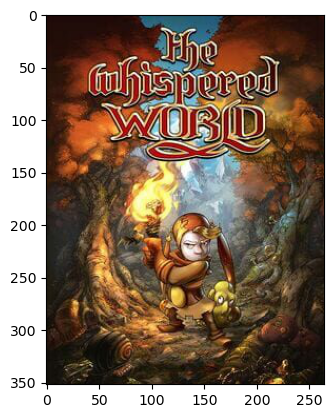

Actual Rating:  40
Predict:  60


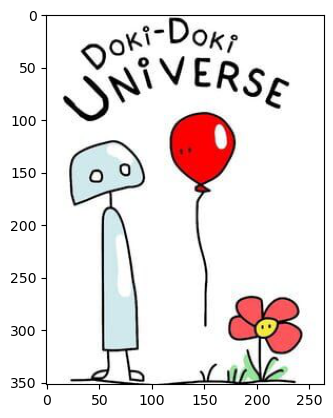

Actual Rating:  40
Predict:  60


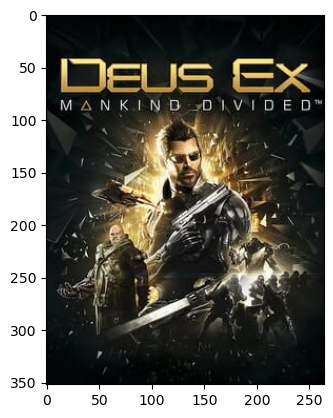

Actual Rating:  60
Predict:  60


In [ ]:
pred_rating_model_resnet18 = Rating_Model(rating_resnet18_v2, 1, 1e-4)
pred_rating_model_resnet18.load_model('rating_resnet18_model_v2.pt')
pred_rating_model_resnet18.model.to(mps_device)

for i in range(3):
    idx = random.randint(0, len(new_filenames))
    label_id = int(new_filenames[idx].split('_')[0])

    file_name = main_dir + new_filenames[idx].split('_')[0] + '.jpg'
    result = rating_predict(pred_rating_model_resnet18.model, file_name)
    ans = (data_rating_v2.loc[label_id] == 1)
    img = mpimg.imread(file_name)
    imgplot = plt.imshow(img)
    act_rating = np.argmax(data_rating_v2.loc[label_id].to_numpy())
    plt.show()
    print('Actual Rating: ', (act_rating * 20))
    print('Predict: ', result * 2)

##### 5.2.2. ResNet50 Model

In [ ]:
from torchvision.models.resnet import ResNet50_Weights
rating_resnet50_v2 = models.resnet50(weights = ResNet50_Weights.DEFAULT)

for param in rating_resnet50_v2.parameters():
    param.requires_grad = False
rating_resnet50_v2.fc = nn.Linear(in_features = 512, out_features = 5)

rating_resnet50_v2.to(mps_device)

rating_resnet50_model_v2 = Rating_Model(rating_resnet50_v2, 10, 1e-4)

In [ ]:
rating_resnet50_model_v2.train()

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


: 

: 

In [ ]:
rating_resnet50_model_v2.test()

##### 5.2.3. VGG16 Model

In [ ]:
from torchvision.models.vgg import VGG16_Weights
rating_vgg16_v2 = models.vgg16(weights = VGG16_Weights.DEFAULT)

for param in rating_vgg16_v2.parameters():
    param.requires_grad = False
rating_vgg16_v2.classifier[6] = nn.Linear(in_features = 4096, out_features = 5)

rating_vgg16_v2.to(mps_device)

rating_vgg16_model_v2 = Rating_Model(rating_vgg16_v2, 10, 1e-4)

In [ ]:
rating_vgg16_model_v2.train()

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


epoch 1, train loss: 0.262, train acc: 45.236
epoch 1, valid loss: 0.242, valid acc: 46.250
epoch 2, train loss: 0.219, train acc: 48.673
epoch 2, valid loss: 0.211, valid acc: 53.750
epoch 3, train loss: 0.198, train acc: 51.345
epoch 3, valid loss: 0.209, valid acc: 50.250
epoch 4, train loss: 0.187, train acc: 52.727
epoch 4, valid loss: 0.194, valid acc: 49.750
epoch 5, train loss: 0.175, train acc: 53.473
epoch 5, valid loss: 0.180, valid acc: 53.000
epoch 6, train loss: 0.166, train acc: 55.364
epoch 6, valid loss: 0.171, valid acc: 52.125
epoch 7, train loss: 0.160, train acc: 56.891
epoch 7, valid loss: 0.165, valid acc: 52.625
epoch 8, train loss: 0.149, train acc: 56.945
epoch 8, valid loss: 0.154, valid acc: 53.500
epoch 9, train loss: 0.145, train acc: 60.109
epoch 9, valid loss: 0.149, valid acc: 53.750
epoch 10, train loss: 0.140, train acc: 60.145
epoch 10, valid loss: 0.150, valid acc: 55.500


In [ ]:
rating_vgg16_model_v2.save_model('rating_vgg16_model_v2.pt')

In [ ]:
rating_vgg16_model_v2.test()

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


test acc: 53.250


LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


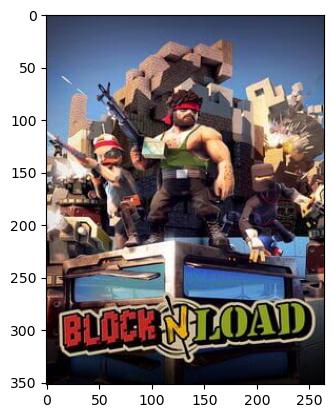

Actual Rating:  40
Predict:  40


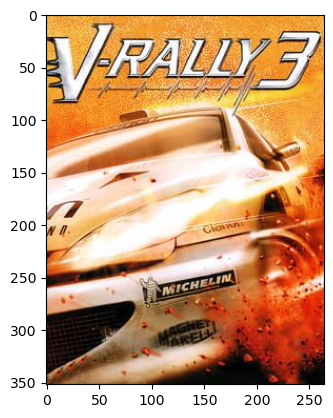

Actual Rating:  60
Predict:  60


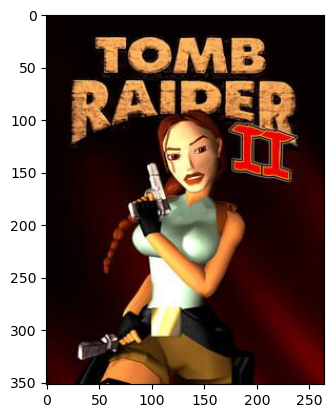

Actual Rating:  60
Predict:  60


In [ ]:
pred_rating_model_vgg16 = Rating_Model(rating_vgg16_v2, 1, 1e-4)
pred_rating_model_vgg16.load_model('rating_vgg16_model_v2.pt')
pred_rating_model_vgg16.model.to(mps_device)

for i in range(3):
    idx = random.randint(0, len(new_filenames))
    label_id = int(new_filenames[idx].split('_')[0])

    file_name = main_dir + new_filenames[idx].split('_')[0] + '.jpg'
    result = rating_predict(pred_rating_model_vgg16.model, file_name)
    ans = (data_rating_v2.loc[label_id] == 1)
    img = mpimg.imread(file_name)
    imgplot = plt.imshow(img)
    act_rating = np.argmax(data_rating_v2.loc[label_id].to_numpy())
    plt.show()
    print('Actual Rating: ', (act_rating * 20))
    print('Predict: ', result * 2)

# 6. Plots Acc and Loss results

In [ ]:
def plot_result(filename):
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            temp = line.split(',')
            new_line = []
            for i in temp:
                new_line.append(i.strip("abcdefghijklmnopqrstuvwxyz :"))
            if 'valid' in line:
                valid_loss.append(float(new_line[1]))
                valid_acc.append(float(new_line[2]))
            else:
                train_loss.append(float(new_line[1]))
                train_acc.append(float(new_line[2]))

        f.close()

    plt.title(filename[8:-4])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(valid_acc, label = 'valid_acc')
    plt.plot(train_acc, label = 'train_acc')
    plt.legend()
    plt.savefig('Results/Plots/' + filename[8:-4] + '_acc.png')
    plt.show()

    plt.title(filename[8:-4])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(valid_loss, label = 'valid_loss')
    plt.plot(train_loss, label = 'train_loss')
    plt.legend()
    plt.savefig('Results/Plots/' + filename[8:-4] + '_loss.png')
    plt.show()


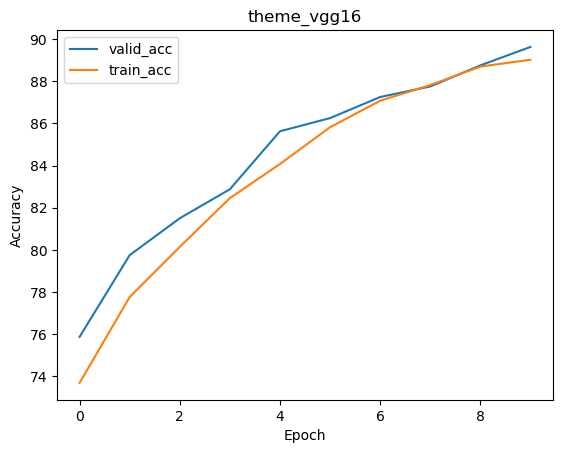

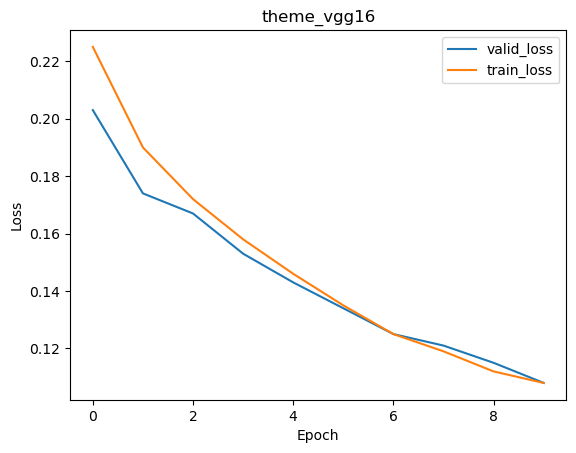

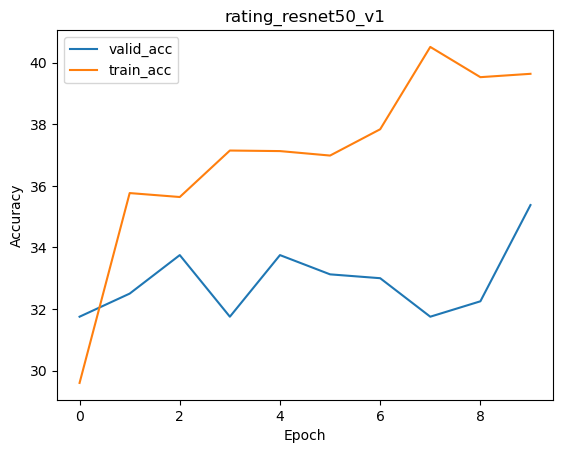

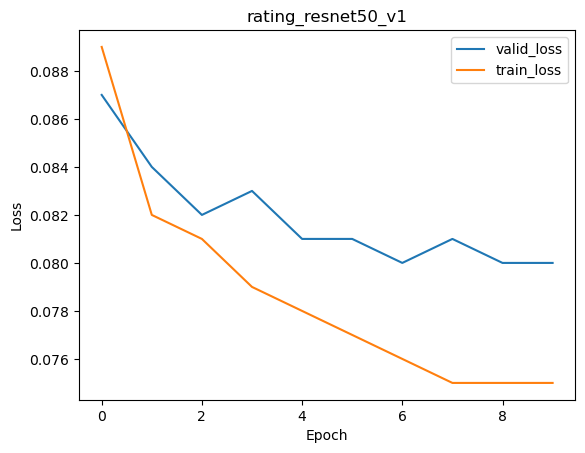

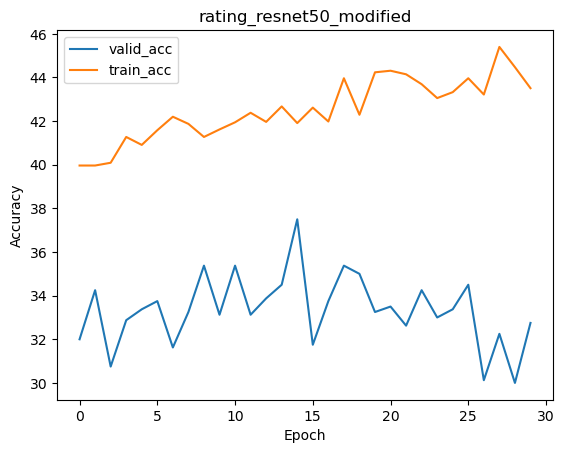

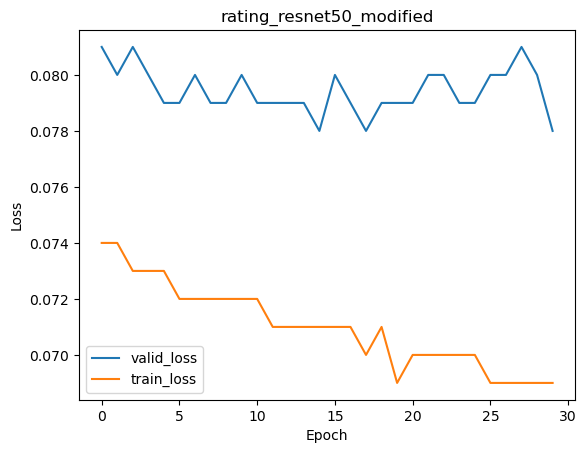

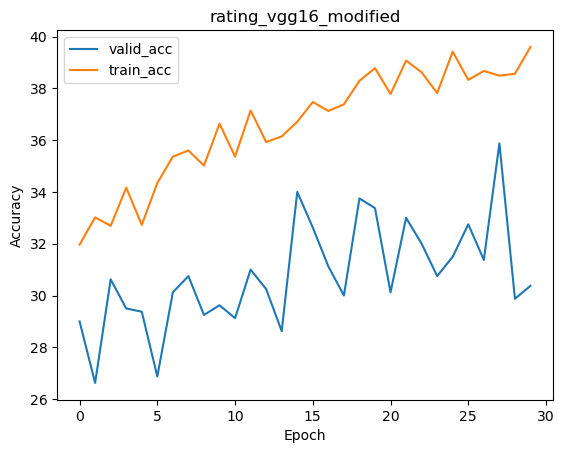

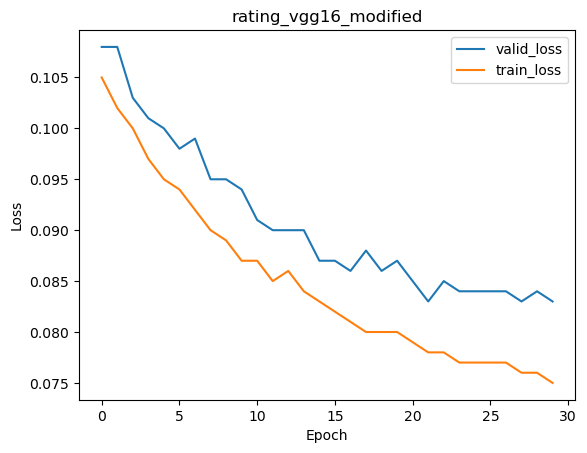

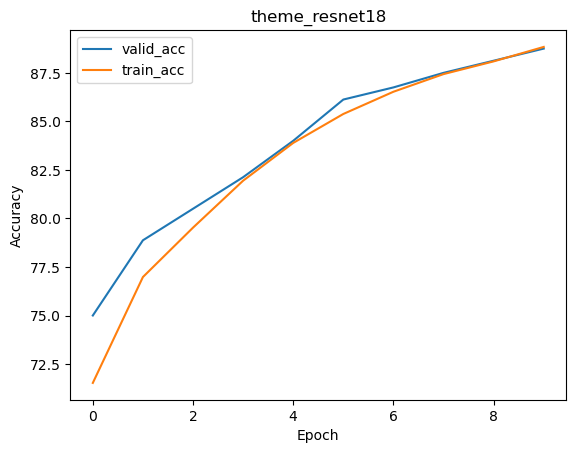

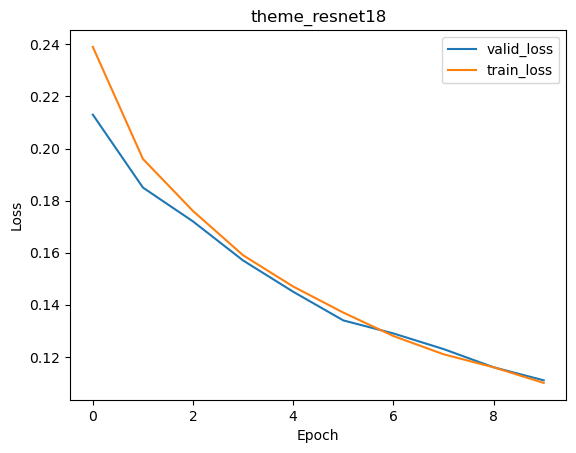

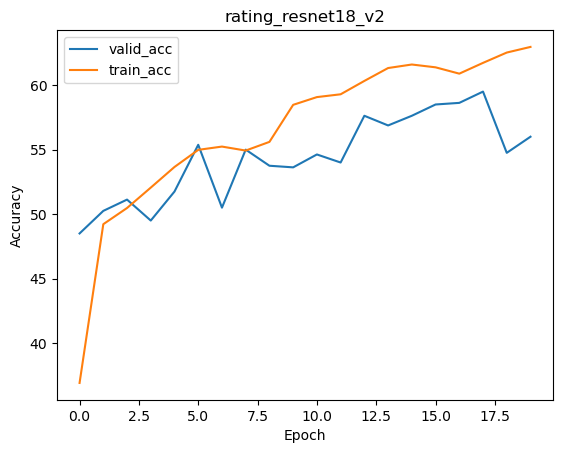

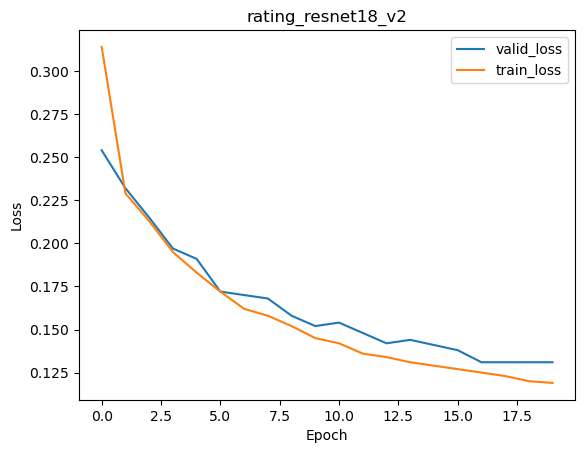

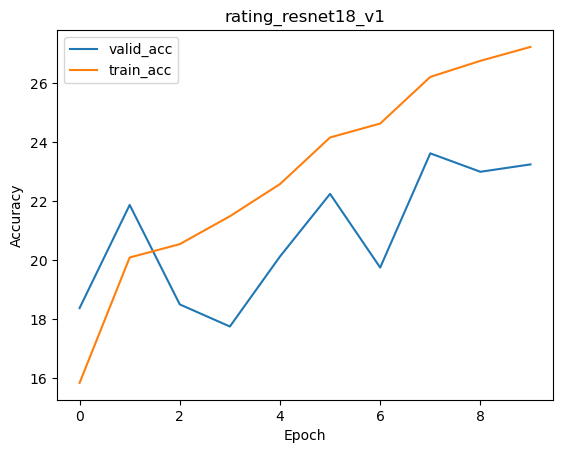

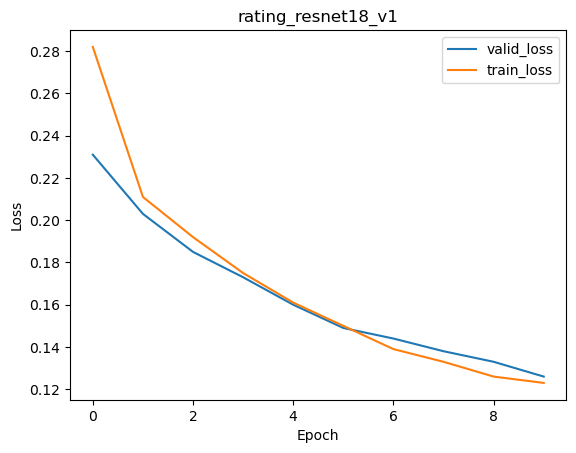

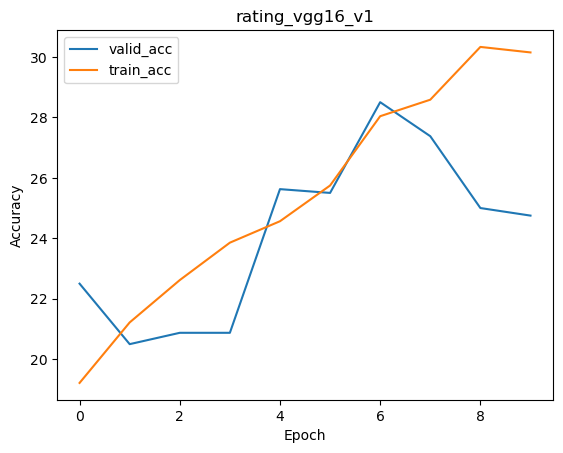

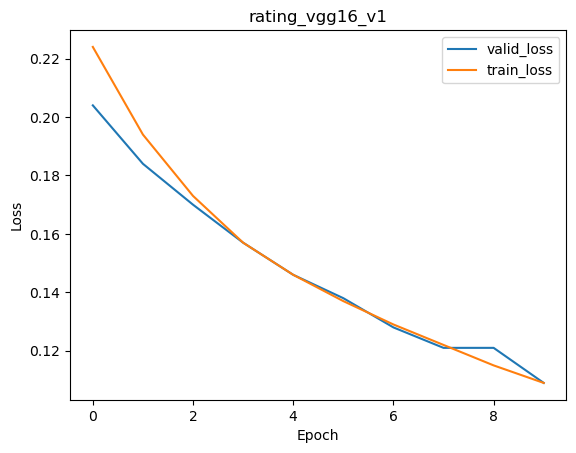

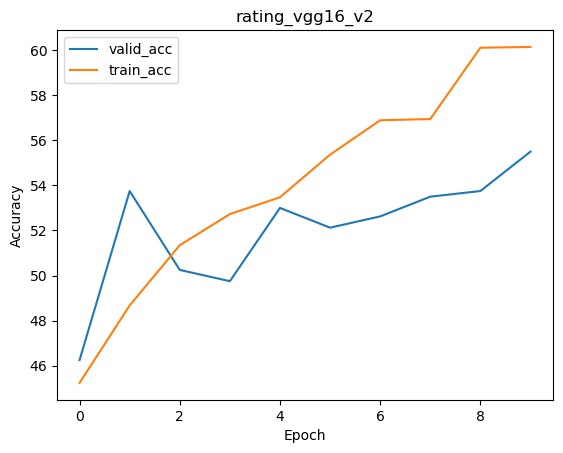

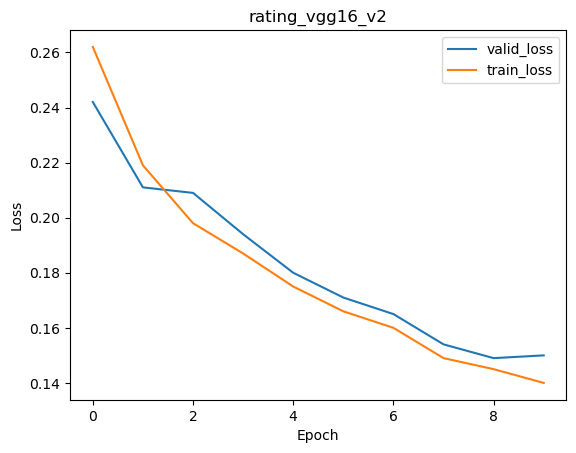

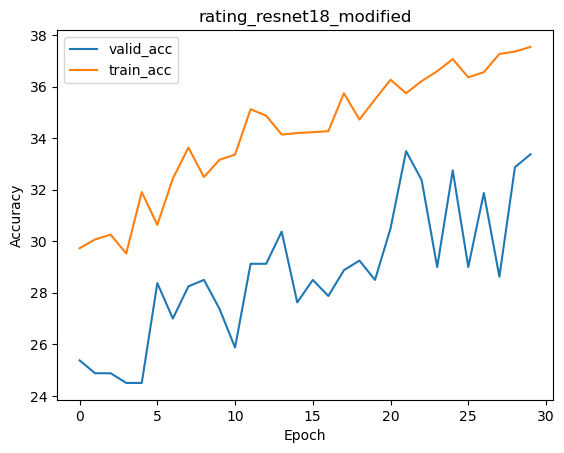

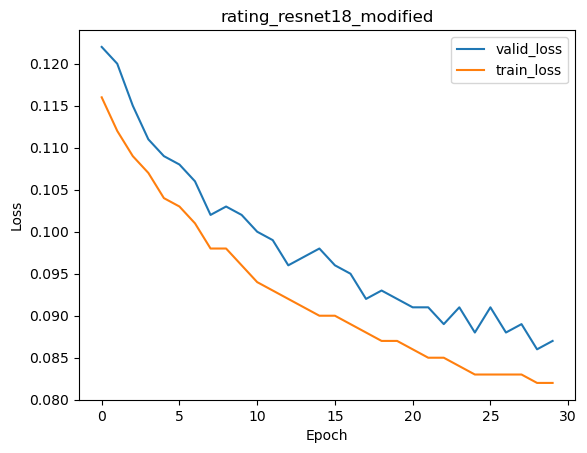

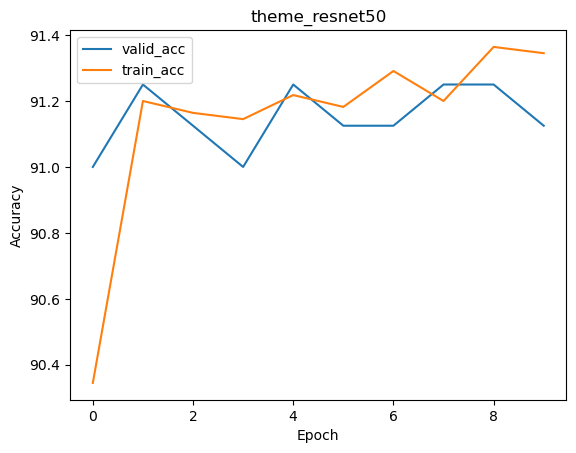

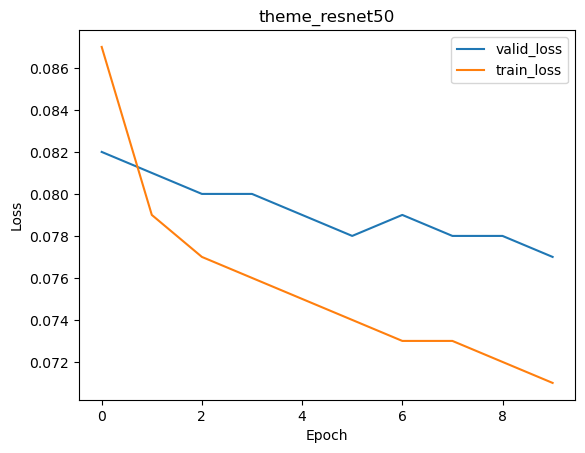

In [ ]:
for i in os.listdir('Results'):
    if 'Plots' in i:
        continue
    plot_result('Results/' + i)


In [ ]:
lines = "epoch 10, valid loss: 0.150, valid acc: 55.500"
lines = lines.split(',')
new_line = []
for i in lines:
    new_line.append(i.strip("abcdefghijklmnopqrstuvwxyz :"))
print(new_line)


# plt.subplot(1,1,1)
    plt.plot(self.train_loss_lst, label = 'train loss')
    plt.plot(self.valid_loss_lst, label = 'valid loss')
    plt.xlabel = 'epoch'
    plt.ylabel = 'loss'
    plt.legend()
    
    plt.show()

    # plt.subplot(1,1,1)
    plt.plot(self.train_acc_lst, label = 'train acc')
    plt.plot(self.valid_acc_lst, label = 'valid acc')
    plt.xlabel = 'epoch'
    plt.ylabel = 'acc'
    plt.legend()
    
    plt.show()

['10', '0.150', '55.500']


# 7. Text Detection and Recognition

### 7.1 Object Detection with YOLOv5n

In [ ]:
import os

import numpy as np
import cv2
import time
import json
from google.colab.patches import cv2_imshow

##### 7.1.1 Prepare model

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U -r yolov5/requirements.txt  # install dependencies

# %cd /content/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14432, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 14432 (delta 35), reused 38 (delta 20), pack-reused 14371
Receiving objects: 100% (14432/14432), 13.57 MiB | 21.34 MiB/s, done.
Resolving deltas: 100% (9936/9936), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 4.3 MB/s 
     |████████████████████████████████| 761 kB 57.9 MB/s 
     |████████████████████████████████| 9.4 MB 71.5 MB/s 
     |████████████████████████████████| 17.1 MB 13.2 MB/s 
     |████████████████████████████████| 3.2 MB 55.5 MB/s 
     |████████████████████████████████| 280 kB 97.8 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 33.8 MB 1.2 MB/s 
     |████████████████████████████████| 6.0 MB 58.7 MB/s 
     |█████████████████████████████

##### 7.1.2 Prepare dataset

In [ ]:
import torch
from IPython.display import Image  # for displaying images
# from utils.google_utils import gdrive_download  # for downloading models/datasets

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.13.0+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="goJwAwFJF3ZclJiMiOUo")
project = rf.workspace("").project("dlcv")
dataset = project.version(1).download("yolov5")

In [ ]:
!mkdir dlcv
%cd dlcv
!curl -L "https://app.roboflow.com/ds/Fz1KJighHx?key=JmkkpCJbde" > roboflow.zip; 
!unzip roboflow.zip; rm roboflow.zip

流式输出内容被截断，只能显示最后 5000 行内容。
 extracting: train/labels/472_jpg.rf.da7b18592de90cecd15b10b122381a6f.txt  
 extracting: train/labels/47445_jpg.rf.45f38e27d86a3ba86c8d12a814c3739e.txt  
 extracting: train/labels/47445_jpg.rf.611c4662747689506bf1c2c480eaf712.txt  
 extracting: train/labels/47445_jpg.rf.89fbc354ed048f9fde78479ebbcb770c.txt  
 extracting: train/labels/47452_jpg.rf.2439cc507fa41a4eddcacc44bc17d300.txt  
 extracting: train/labels/47452_jpg.rf.2fd7950122d5b4ecd5a384a6824f48bf.txt  
 extracting: train/labels/47452_jpg.rf.c0f54e8b6a5460cf904e2b3df49e96d8.txt  
 extracting: train/labels/4747_jpg.rf.207699761dd8e8c5dcbdd3e47ce1a7d8.txt  
 extracting: train/labels/474_jpg.rf.5596e2381119548084dbf3d36c6556ec.txt  
 extracting: train/labels/474_jpg.rf.9c79331a49cbe28570599615bb3c486e.txt  
 extracting: train/labels/474_jpg.rf.a89ef6dfc349c17817bc1ce5faad6205.txt  
 extracting: train/labels/4755_jpg.rf.8968f616ac2238c272228c3e20f45064.txt  
 extracting: train/labels/4755_jpg.rf.d4d8361b0

##### 7.1.3 Train model

In [ ]:
%cd /content
%cd yolov5

!python train.py --data ./dlcv/data.yaml \
  --img 416 --batch 32 --epochs 40 \
  --optimizer Adam \
  --weights yolov5n.pt \
  --workers 8 

/content
/content/yolov5
train: weights=yolov5n.pt, cfg=, data=./dlcv/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=40, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h

### 7.2 Text recognition with PaddleOCR

##### 7.2.1 Prepare environment

In [ ]:
!nvcc --version
!nvidia-smi

!pip install chainer
import chainer

print("-----------------SYSTEM INFO----------------------")
chainer.print_runtime_info()

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Fri Dec  9 12:20:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   1206MiB / 15109MiB |      0%      Default |
|                               |      

In [ ]:
# install CUDNN
%cd /content
!sudo dpkg -i libcudnn8-dev_8.2.0.53-1+cuda11.3_amd64.deb
!sudo dpkg -i libcudnn8-samples_8.2.0.53-1+cuda11.3_amd64.deb
!sudo dpkg -i libcudnn8_8.2.0.53-1+cuda11.3_amd64.deb

# https://developer.nvidia.com/compute/machine-learning/cudnn/secure/8.2.0.53/11.3_04222021/Ubuntu18_04-x64/libcudnn8_8.2.0.53-1+cuda11.3_amd64.deb

!sudo cp /usr/include/cudnn.h /usr/local/cuda-11.2/include
!sudo chmod a+x /usr/local/cuda-11.2/include/cudnn.h

!cat /usr/local/cuda-11.2/include/cudnn.h | grep CUDNN_MAJOR -A 2

/content
(Reading database ... 124075 files and directories currently installed.)
Preparing to unpack libcudnn8-dev_8.2.0.53-1+cuda11.3_amd64.deb ...
Unpacking libcudnn8-dev (8.2.0.53-1+cuda11.3) over (8.2.0.53-1+cuda11.3) ...
Setting up libcudnn8-dev (8.2.0.53-1+cuda11.3) ...
update-alternatives: using /usr/include/x86_64-linux-gnu/cudnn_v8.h to provide /usr/include/cudnn.h (libcudnn) in auto mode
(Reading database ... 124075 files and directories currently installed.)
Preparing to unpack libcudnn8-samples_8.2.0.53-1+cuda11.3_amd64.deb ...
Unpacking libcudnn8-samples (8.2.0.53-1+cuda11.3) over (8.2.0.53-1+cuda11.3) ...
Setting up libcudnn8-samples (8.2.0.53-1+cuda11.3) ...
(Reading database ... 124075 files and directories currently installed.)
Preparing to unpack libcudnn8_8.2.0.53-1+cuda11.3_amd64.deb ...
Unpacking libcudnn8 (8.2.0.53-1+cuda11.3) over (8.2.0.53-1+cuda11.3) ...
Setting up libcudnn8 (8.2.0.53-1+cuda11.3) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...


##### 7.2.2 Prepare model

In [ ]:
!python -m pip install paddlepaddle-gpu==2.4.0.post112 -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html

import paddle
paddle.utils.run_check()

print(paddle.__version__)

In [ ]:
# !pip install "paddleocr>=2.0.1"
!git clone https://github.com/PaddlePaddle/PaddleOCR
%cd PaddleOCR
!pip3 install -r ./requirements.txt
%cd ..

Cloning into 'PaddleOCR'...
remote: Enumerating objects: 45108, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 45108 (delta 105), reused 159 (delta 60), pack-reused 44869
Receiving objects: 100% (45108/45108), 338.36 MiB | 45.31 MiB/s, done.
Resolving deltas: 100% (31781/31781), done.
/content/PaddleOCR
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 619 kB 5.1 MB/s 
     |████████████████████████████████| 4.9 MB 63.7 MB/s 
     |████████████████████████████████| 2.2 MB 61.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 8.8 MB 95.0 MB/s 
     |████████████████████████████████| 204 kB 102.5 MB/s 
     |████████████████████████████████| 132 kB 99.7 MB/s 
     |████████████████████████████████| 399 kB 78.

##### 7.2.3 Prepare dataset

In [ ]:
!rm -rf ./coco
!mkdir coco
%cd coco
!curl -L "https://app.roboflow.com/ds/4DiyQZLNxD?key=dFiHETL0sF" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd ..

In [ ]:
"""
transfer data format from coco to dataset
prepare the data for the PaddleOCR

Use the RFL model
"""

import os
import cv2
import json

import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow

import pdb

%cd /content
!rm -rf ./game_OCR
!mkdir game_OCR

data_path = './coco'
output_path = './game_OCR'
data_parts = ['train', 'test', 'valid']

meta_data_path = './Image_5000.csv'

def load_meta_data(meta_data_path):
  
  meta_dt = pd.read_csv(meta_data_path)
  meta_data_id = meta_dt['0'].tolist()
  meta_data_name = meta_dt['1'].tolist()

  meta_data = {}
  for i in range(len(meta_data_id)):
    meta_data[str(meta_data_id[i])] = meta_data_name[i] 

  # pdb.set_trace()

  return meta_data

"""
"images":[{"id":0,"license":1,"file_name":"284_jpg.rf.0119e1794a4928e6f97bf9d7ebb35fa0.jpg","height":416,"width":416,"date_captured":"2022-12-08T09:17:34+00:00"}
annotations":[{"id":0,"image_id":0,"category_id":1,"bbox":[44,20,333,90],"area":29970,"segmentation":[],"iscrowd":0}
"""
def prepare_RFL_data(data_path, output_path, meta_data):
  annotation_file_name = '_annotations.coco.json'

  for data_part in data_parts:
    #
    data_part_path = os.path.join(data_path, data_part)
    annotation_path = os.path.join(data_part_path, annotation_file_name)

    # output images path
    output_root_path = output_path + '/' + data_part + '_data'
    os.mkdir(output_root_path)
    output_rec_path = output_root_path + '/rec'
    os.mkdir(output_rec_path)
    output_part_path = os.path.join(output_rec_path, data_part)
    os.mkdir(output_part_path)
    output_meta_path = os.path.join(output_rec_path, 'rec_gt_' + data_part + '.txt')

    # load the annotation file
    with open(annotation_path, 'r', encoding='utf-8') as f:
      annotation_json = json.load(f)
      f.close()

    # save the imgs by annotations
    images = annotation_json['images']
    annotations = annotation_json['annotations']

    # pdb.set_trace()

    with open(output_meta_path, 'a', encoding='utf-8') as f:
      
      count = 0
      for annotation in annotations:
        for image in images:
          if annotation['image_id'] == image['id']:
            # load image
            # pdb.set_trace()
            img_name = image['file_name']
            img_path = os.path.join(data_part_path, img_name)
            img = cv2.imread(img_path)

            # img process
            # cut the img by annotation bbox
            bbox = annotation['bbox']
            x, y, w, h = bbox
            img = img[int(y) : int(y + h), 
                  int(x) : int(x + w), :]
            # pdb.set_trace()
            # transfer to the BGR format
            # normalization
            # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # img = cv2.resize(img, (224, 64)).reshape(224, 64, 1) # .reshape((-1, 32, 224))

            # save the img meta data - img_name
            img_name_splits = img_name.split('.')
            img_id = img_name_splits[0].strip('_jpg')
            img_label = meta_data[img_id]

            # save img
            img_output_name = img_id + '.jpg'
            img_output_path = os.path.join(output_part_path, img_output_name)
            # pdb.set_trace()
            # if isinstance(img, np.ndarray) and img.size != 0:
            cv2.imwrite(img_output_path, img)
            # output img_label
            f.write(img_output_name + '\t' + img_label + '\n')
            count += 1

            break

      f.close()
      print('{} data contains {} images'.format(data_part, count))

  
meta_data = load_meta_data(meta_data_path)
prepare_RFL_data(data_path, output_path, meta_data)

/content
train data contains 4044 images
test data contains 103 images
valid data contains 385 images


In [ ]:
!zip -q -r ./game_OCR.zip ./game_OCR

In [ ]:
%cd PaddleOCR
# ! wget -P ./pretrain_models/ https://paddleocr.bj.bcebos.com/contribution/rec_resnet_rfl_visual_train.tar
%cd ./pretrained_models
! tar -xf rec_resnet_rfl_visual_train.tar; rm -rf rec_resnet_rfl_visual_train.tar
%cd ..

/content/PaddleOCR
[Errno 2] No such file or directory: './pretrained_models'
/content/PaddleOCR
tar: rec_resnet_rfl_visual_train.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
/content


##### 7.2.4 Train model PP-OCRv3

In [ ]:
%cd PaddleOCR/
# 
!wget -P ./pretrain_models/ https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_train.tar
# 
%cd pretrain_models
!tar -xf en_PP-OCRv3_rec_train.tar && rm -rf en_PP-OCRv3_rec_train.tar

/content/PaddleOCR/pretrain_models


In [ ]:
# train & eval
%cd PaddleOCR
# !pwd
# !python3 tools/train.py -c ../game_rfl_visual.yml 
!python3 tools/train.py -c ../en_PP-OCRv3_rec.yml 

[Errno 2] No such file or directory: 'PaddleOCR'
/content/PaddleOCR
[2022/12/08 16:33:01] ppocr INFO: Architecture : 
[2022/12/08 16:33:01] ppocr INFO:     Backbone : 
[2022/12/08 16:33:01] ppocr INFO:         last_conv_stride : [1, 2]
[2022/12/08 16:33:01] ppocr INFO:         last_pool_type : avg
[2022/12/08 16:33:01] ppocr INFO:         name : MobileNetV1Enhance
[2022/12/08 16:33:01] ppocr INFO:         scale : 0.5
[2022/12/08 16:33:01] ppocr INFO:     Head : 
[2022/12/08 16:33:01] ppocr INFO:         head_list : 
[2022/12/08 16:33:01] ppocr INFO:             CTCHead : 
[2022/12/08 16:33:01] ppocr INFO:                 Head : 
[2022/12/08 16:33:01] ppocr INFO:                     fc_decay : 1e-05
[2022/12/08 16:33:01] ppocr INFO:                 Neck : 
[2022/12/08 16:33:01] ppocr INFO:                     depth : 2
[2022/12/08 16:33:01] ppocr INFO:                     dims : 64
[2022/12/08 16:33:01] ppocr INFO:                     hidden_dims : 120
[2022/12/08 16:33:01] ppocr INFO: 

### 7.3 Model Inference

In [ ]:
%cd /content

! cp ./drive/MyDrive/courses/dabaobei/dlcv-fall22/final/best_state_1219.zip ./
! unzip best_state_1219.zip
! cp ./drive/MyDrive/courses/dabaobei/dlcv-fall22/final/yolo5n.zip ./
! unzip yolo5n.zip

/content
Archive:  best_state_1219.zip
  inflating: best_state_1219/best_accuracy.pdopt  
  inflating: best_state_1219/best_accuracy.pdparams  
  inflating: best_state_1219/best_accuracy.states  
Archive:  yolo5n.zip
   creating: runs/train/exp4/
   creating: runs/train/exp4/weights/
  inflating: runs/train/exp4/weights/best.pt  
  inflating: runs/train/exp4/weights/last.pt  
  inflating: runs/train/exp4/train_batch0.jpg  
  inflating: runs/train/exp4/val_batch0_pred.jpg  
  inflating: runs/train/exp4/val_batch1_pred.jpg  
  inflating: runs/train/exp4/results.csv  
  inflating: runs/train/exp4/P_curve.png  
  inflating: runs/train/exp4/val_batch2_labels.jpg  
  inflating: runs/train/exp4/train_batch1.jpg  
  inflating: runs/train/exp4/opt.yaml  
  inflating: runs/train/exp4/val_batch1_labels.jpg  
  inflating: runs/train/exp4/PR_curve.png  
  inflating: runs/train/exp4/val_batch2_pred.jpg  
  inflating: runs/train/exp4/labels_correlogram.jpg  
  inflating: runs/train/exp4/hyp.yaml  
  

In [ ]:
# 
import cv2
import pandas as pd
import torch

from google.colab.patches import cv2_imshow

test_img = './55044.jpg'

model_n = torch.hub.load('ultralytics/yolov5', 'custom', './runs/train/exp4/weights/best.pt')
model_n.eval()

img = cv2.imread(test_img)[..., ::-1]
results = model_n(img, size=416)

print(results)
results.pandas().xyxy[0]
# 

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-9 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients
Adding AutoShape... 


image 1/1: 352x264 1 Name
Speed: 2.8ms pre-process, 15.7ms inference, 2.1ms NMS per image at shape (1, 3, 416, 320)


xmin        ymin        xmax        ymax  confidence  class  name
0  4.436769  248.168396  257.781403  341.322327    0.613412      0  Name

ori_img


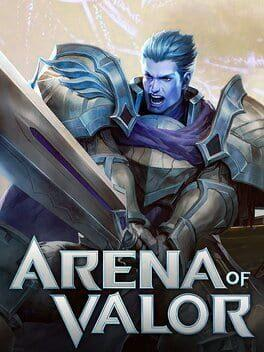

--------------------
detection bbox img


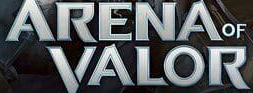

True

In [ ]:
# visulization

!mkdir test_dir
bbox_img_path = './test_dir/bbox_img.jpg'

bbox = results.pandas().xyxy[0].values.tolist()
bbox = bbox[0]

print('ori_img')
cv2_imshow(img)
print('--------------------')
print('detection bbox img')
bbox_img = img[int(bbox[1]) : int(bbox[3]),
        int(bbox[0]) : int(bbox[2]), :]
cv2_imshow(bbox_img)
cv2.imwrite(bbox_img_path, bbox_img)

In [ ]:
# -c 
# -o 
# Global.pretrained_model 
# Global.save_inference_dir

%cd /content
! cp ./drive/MyDrive/courses/dabaobei/dlcv-fall22/final/en_PP-OCRv3_rec.yml ./

%cd ./PaddleOCR
!python3 tools/export_model.py -c ../en_PP-OCRv3_rec.yml \
  -o Global.pretrained_model=../best_state_1219/best_accuracy \
  Global.save_inference_dir=./inference/en_PP-OCRv3_rec/

/content
/content/PaddleOCR
PLEASE USE OMP_NUM_THREADS WISELY.
W1209 12:35:57.838496  1300 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 11.2, Runtime API Version: 11.2
W1209 12:35:57.840808  1300 gpu_resources.cc:91] device: 0, cuDNN Version: 8.1.
[2022/12/09 12:35:58] ppocr INFO: load pretrain successful from ../best_state_1219/best_accuracy
[2022/12/09 12:35:59] ppocr INFO: inference model is saved to ./inference/en_PP-OCRv3_rec/inference


In [ ]:
# text recognization

! mkdir text_rec_output

%cd PaddleOCR

print('text recognization result')

! python3 tools/infer/predict_rec.py --image_dir="../test_dir/bbox_img.jpg" \
  --rec_model_dir="./inference/en_PP-OCRv3_rec/" \
  --rec_image_shape="3, 32, 320" # --rec_char_dict_path="../text_rec_output"

%cd /content

mkdir: cannot create directory ‘text_rec_output’: File exists
/content/PaddleOCR
PLEASE USE OMP_NUM_THREADS WISELY.
[2022/12/09 12:36:24] ppocr INFO: In PP-OCRv3, rec_image_shape parameter defaults to '3, 48, 320', if you are using recognition model with PP-OCRv2 or an older version, please set --rec_image_shape='3,32,320
[2022/12/09 12:36:30] ppocr INFO: Predicts of ../test_dir/bbox_img.jpg:('ARELA OF VALOU', 0.7498286366462708)
/content


# 8. Predict

### 8.1. Prediction Code

In [9]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
import requests
import json

from glob import glob

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import urllib.request
import os

from os.path import exists

import pandas as pd

import numpy as np

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import cos, sin, radians, log10
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import PIL
import torchvision.models as models
import cv2

from google.colab.patches import cv2_imshow

from torchvision.models.resnet import ResNet50_Weights
from torchvision.models.resnet import ResNet18_Weights

In [14]:
path = '/content/gdrive/MyDrive/DLCV 4995 Final Project/final_submit_version/'
theme_model_dir = path + 'models/theme_resnet50_model.pt'
rating_model_dir = path + 'models/rating_resnet18_model_v2.pt'

# Theme Model
theme_resnet50 = models.resnet50(weights = ResNet50_Weights.DEFAULT)
for param in theme_resnet50.parameters():
    param.requires_grad = False
theme_resnet50.fc = nn.Linear(in_features = 2048, out_features = 22)
theme_resnet50.load_state_dict(torch.load(theme_model_dir))

data = pd.read_csv(path +'Image_5000.csv')
data = data.rename(columns = {'0': 'id', '1': 'Name', '2': 'Theme', '3': 'Rating', '4': 'URL'})
labels = data['Theme'].str.strip("[]").str.get_dummies(', ').rename(columns=lambda x: x.strip("'")).iloc[:, :22].join(data['id']).set_index('id')
theme_label_names = labels.columns


# Rating Model
data_rating = (round(data.Rating / 20) - 1).astype(int).astype(str)
data_rating = data_rating.str.get_dummies().join(data['id']).set_index('id')

rating_resnet18 = models.resnet18(weights = ResNet18_Weights.DEFAULT)
for param in rating_resnet18.parameters():
    param.requires_grad = False
rating_resnet18.fc = nn.Linear(in_features = 512, out_features = 5)
rating_resnet18.load_state_dict(torch.load(rating_model_dir))

def theme_predict(model, img_filename):
    img = cv2.imread(img_filename)
    img = transforms.ToPILImage()(img)
    # convert to tensor
    img = img.resize([224, 224], resample=PIL.Image.LANCZOS)

    image_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[1.0]),
    ])
    img = image_transforms(img)
    img = img.view(1, 3, 224, 224)
    # img = img.to(mps_device)
    # forward pass
    output = model(img)

    output = torch.argsort(output, descending=True).numpy()

    result = []
    result.append(theme_label_names[output[0][0]])
    result.append(theme_label_names[output[0][1]])
    return result

def rating_predict(model, img_filename):
    img = cv2.imread(img_filename)
    img = transforms.ToPILImage()(img)
    # convert to tensor
    img = img.resize([224, 224], resample=PIL.Image.LANCZOS)

    image_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[1.0]),
    ])
    img = image_transforms(img)
    img = img.view(1, 3, 224, 224)
    # forward pass
    output = model(img)
    # output = output.cpu()

    output = torch.argmax(output).numpy()
    result = output * 20

    return result

def predict (file_name):
    # Drawing Image Box
    test_img = file_name

    model_n = torch.hub.load('ultralytics/yolov5', 'custom', path + 'runs/train/exp4/weights/best.pt')
    # model_n.eval()

    img = cv2.imread(test_img)[..., ::-1]
    results = model_n(img, size=416)

    # print(res ults)
    results.pandas().xyxy[0]

    bbox_img_path = './bbox_img.jpg'

    bbox = results.pandas().xyxy[0].values.tolist()
    bbox = bbox[0]

    # print('ori_img')
    cv2_imshow(img)
    print('--------------------')
    # print('detection bbox img')
    bbox_img = img[int(bbox[1]) : int(bbox[3]),
                int(bbox[0]) : int(bbox[2]), :]
    # cv2_imshow(bbox_img)
    # cv2.imwrite(bbox_img_path, bbox_img) 

    # Predict Theme
    theme = theme_predict(theme_resnet50, test_img)
    
    # Predict Rating
    rating = rating_predict(rating_resnet18, test_img)
    
    print('The image title is located at: ')
    cv2_imshow(bbox_img)
    print(f'This is a {theme[0]} and {theme[1]} video game, expected rating {rating}/100.')


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-10 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients
Adding AutoShape... 


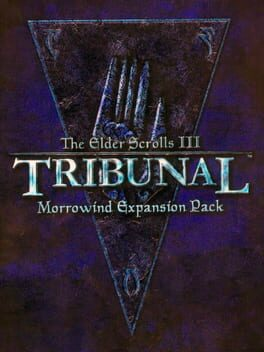

--------------------
The image title is located at: 


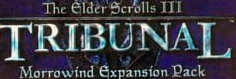

This is a Action and Science fiction video game, expected rating 60/100.


In [16]:
file_name = 'test.jpg'
test_img_name = path + file_name
predict(test_img_name)